In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns 
sns.set_style('ticks')

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

import pickle
import re
import os
import copy

from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data


from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

Set Theano Environmental Variables for Parallelisation


In [3]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [4]:
default_res = pickle.load(open("traces/final_full.pkl", "rb")).CMReduction

In [5]:
results_base_dir = "../../server/sensitivity_default_final/"

def tag_fname_to_label(tag, fname):    
    if tag == "cases_threshold":
        r = re.search(r"(cases_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "deaths_threshold":
        r = re.search(r"(deaths_t)(\d*)", fname)
        return r.groups()[1]
    
    if tag == "any_npi_active":
        return "Bonus Any-Active NPI"
    
    if tag == "delay_schools":
        return "School & University\nClosure Delayed"
    
    if tag == "npi_leaveout":
        npi_names = data.CMs
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
            
        return label
    
    if tag == "growth_noise":
        npi_names = data.CMs
        r = re.search(r"(growth_noise)-(\d*.\d*)", fname)
        
        return r.groups()[1]
            
    if tag == "NPI_prior":
        if "icl" in fname:
            return "Flaxman et. al."
        
        if "normal" in fname:
            return "Normal"
        
    if tag == "oxcgrt":
        npi_names = ['Travel Screen/Quarantine', 'Travel Bans', 'Public Transport Limited',
                          'Internal Movement Limited', 'Public Information Campaigns', 'Symptomatic Testing']
        r = re.search(r"(\d*)", fname)[0]
        label = f"{npi_names[int(r[0])]}"
        for npi in r[1:]:
            label += f",\n{npi_names[int(npi)]}"
        return label
            
    if tag == "R_prior":
        r = re.search(r"(R_prior-)(\d*.\d*)", fname)
        val = r.groups()[1]
        label = f"$\\bar{{R}}$ = {val}"
        return label

    if tag == "region_holdout":
        return fname[:2]
    
    if tag == "structural":
        if "additive" in fname:
            return "Additive"
        if "different_effects" in fname:
            return "Different Effects"
        if "cases" in fname:
            return "Only Case Data"
        if "deaths" in fname:
            return "Only Death Data"
        if "noisy" in fname:
            return "Noisy-R"
        if "discrete_renewal_fixed_gi" in fname:
            return "Discrete Renewal (Fixed GI)"
        if "discrete_renewal" in fname:
            return  "Discrete Renewal (Unknown GI)"
        
    if tag == "epiparam_prior":
        gi = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        cd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        dd = re.search(r"(gi_mean_mean-)(\d*.\d*)", fname)[1]
        
        
    return f"{tag} - {fname}"

def load_tagged_traces(result_base_dir, tag):
    path = os.path.join(results_base_dir, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and 'CasesDelay' not in f and 'DeathsDeath' not in f and '_GI_' not in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    all_traces.append([trace, tag_fname_to_label(tag, f)])
                except Exception as e:
                    print(e)
                    
    return all_traces

def search_tagged_traces(result_base_dir, tag, search_key):
    path = os.path.join(results_base_dir, tag)
    
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f and search_key in f:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    label =  tag_fname_to_label(tag, f)
                    return (trace, label)
    
    print('No experiment found')
    return None

In [6]:
colors = [*sns.color_palette("colorblind"), *sns.color_palette("bright")]

derived_features_comb = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2, 1]),
 ("Gatherings limited to 10\npeople or less", [3, 2, 1]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [4, 5]),
 ("Schools and universities closed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]


derived_features_uncomb = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2]),
 ("Gatherings limited to 10\npeople or less", [3]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [5]),
 ("Schools and universities closed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]

derived_features = derived_features_comb

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
def add_additive_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.zeros(nS)
        for r in prodrows:
            samples = samples + res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*res
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        if cm > 7:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25*0.25, linewidth=width, linestyle="--")
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75*0.25, linewidth=width, linestyle="--")
        else:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
        
        
def setup_large_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average marginal multiplicative reduction in $R$,\nin the context of our data", fontsize=8)
        
def setup_larger_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 9*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=12, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average marginal multiplicative reduction in $R$, in the context of our data", fontsize=8)
    
def setup_small_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [0, 50, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 13*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average marginal multiplicative reduction in $R$, in the context of our data", fontsize=8)
        
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]

In [7]:
def produce_score(default_res, traces, exclude=None):
    default_med = 1 - np.median(default_res, axis=0)
    
    regression_table = np.zeros((0, 2))
    labels_used = []
    
    for trace, label in traces:
        if exclude is not None:
            if isinstance(exclude, list):
                flags = [e in label for e in exclude]
                if any(flags):
                    continue
            else:
                if exclude in label:
                    continue
        
        med = 1 - np.median(trace[:, :9], axis=0)
        med = 1 - med if 'Additive' in label else med
        
        regression_table = np.append(regression_table, np.vstack([default_med, med]).T, axis=0)
        labels_used.append(label)
    
    mask = ~ np.any(np.isnan(regression_table), axis=-1)
    _, _, score, _, _ = stats.linregress(regression_table[mask])
    
    print(f'Produced stored using {[labels_used]}')
    return score

# Category 1: Structural Sensitivity

In [399]:
traces = load_tagged_traces(results_base_dir, 'structural')
score = produce_score(default_res, traces, ['Only', 'Unknown', 'Additive'])
traces = [(trace, label) for trace, label in traces if ('Only' not in label and 'Additive' not in label and 'Unknown' not in label)]

fig = plt.figure(figsize=(10, 3), dpi=300)
plt.subplot(121)
setup_large_plot()
y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width) 
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper center", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Structural Sensitivity (Main)", fontsize="10")

plt.subplot(122)
setup_large_plot(False, False, True)
trace, label = search_tagged_traces(results_base_dir, 'structural', 'additive')
add_additive_trace_to_plot(trace, 0, colors[0], label, 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6)
plt.title("Structural Sensitivity (Additive Model)", fontsize="10")
plt.xlabel("Average marginal additive reduction in $R$,\nin the context of our data", fontsize=8)

plt.tight_layout()
plt.savefig(f"figs/validation/FigSSAMain.pdf", bbox_inches='tight')

Produced stored using [['Noisy-R', 'Discrete Renewal (Fixed GI)', 'Different Effects']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


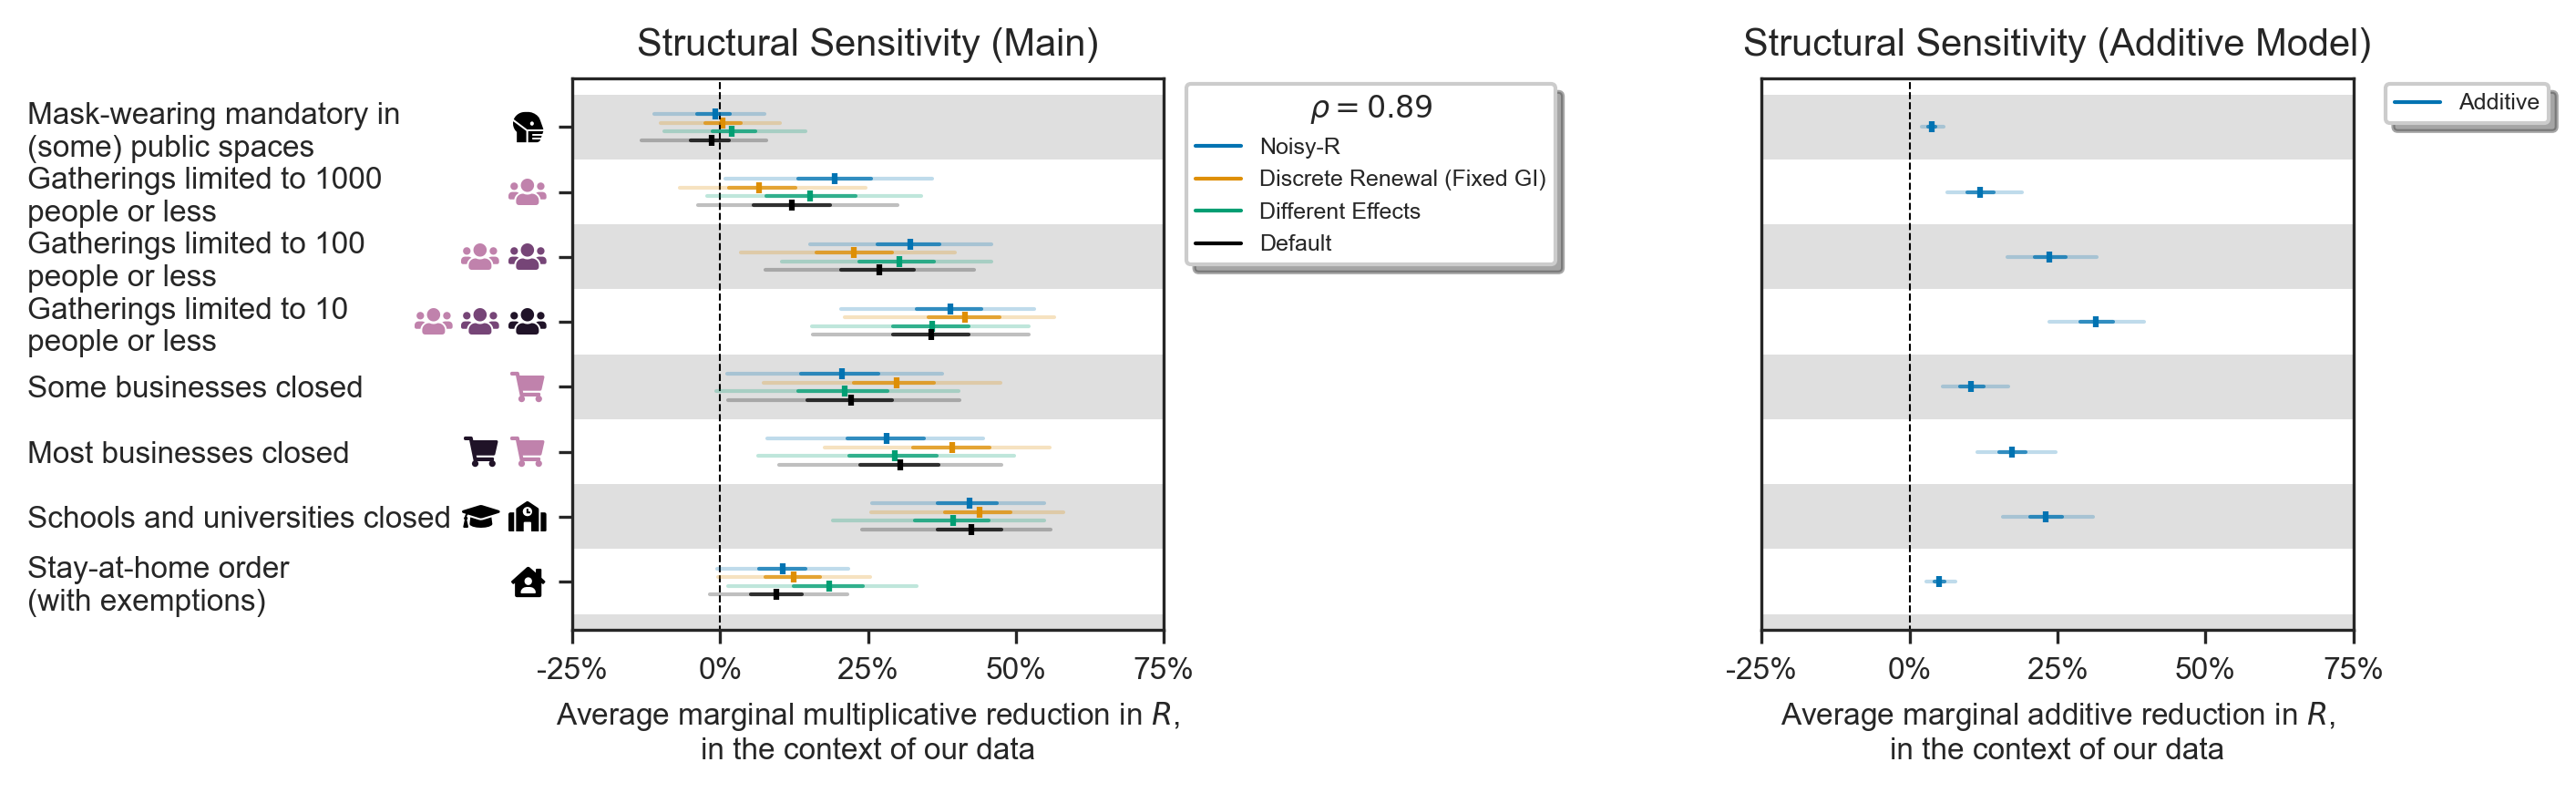

In [400]:
f;

# Category 2: Unobserved Effects

In [412]:
fig = plt.figure(figsize=(10, 3), dpi=300)

plt.subplot(121)
setup_large_plot()

traces = load_tagged_traces(results_base_dir, "oxcgrt")
testing_index = [n for _, n in traces].index('Symptomatic Testing')
orig = copy.deepcopy(traces[testing_index][0])
traces[testing_index][0] = orig[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]]
        
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Inclusion of OxCGRT NPIs", fontsize="10")

plt.subplot(122)
derived_features = derived_features_uncomb
setup_large_plot(False, True, True)
traces = load_tagged_traces(results_base_dir, "npi_leaveout")

# remove values which are invalid!
labels = [l for _, l in traces]
for l_i, label in enumerate(labels):
    for cm_i, cm in enumerate(data.CMs):
        if cm in label:
            traces[l_i][0][:, cm_i] = np.nan
        
score = produce_score(default_res, traces)

order = [*data.CMs, "School Closure,\nUniversity Closure"]
t_is = [labels.index(o) for o in order]

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 1
for i, t_i in enumerate(t_is):
    trace, label = traces[t_i]
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 
    
derived_features = derived_features_comb

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Exclusion of Collected NPIs\nUncombined Effect Shown", fontsize="10")
plt.tight_layout()
plt.savefig(f"figs/validation/FigureUOB_main.pdf", bbox_inches='tight')

Produced stored using [['Travel Screen/Quarantine,\nTravel Bans', 'Symptomatic Testing', 'Public Information Campaigns', 'Internal Movement Limited', 'Public Transport Limited']]
Produced stored using [['School Closure,\nUniversity Closure', 'Stay Home Order', 'Most Businesses Suspended', 'Some Businesses Suspended', 'School Closure', 'University Closure', 'Gatherings <10', 'Gatherings <100', 'Mask Wearing', 'Gatherings <1000']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


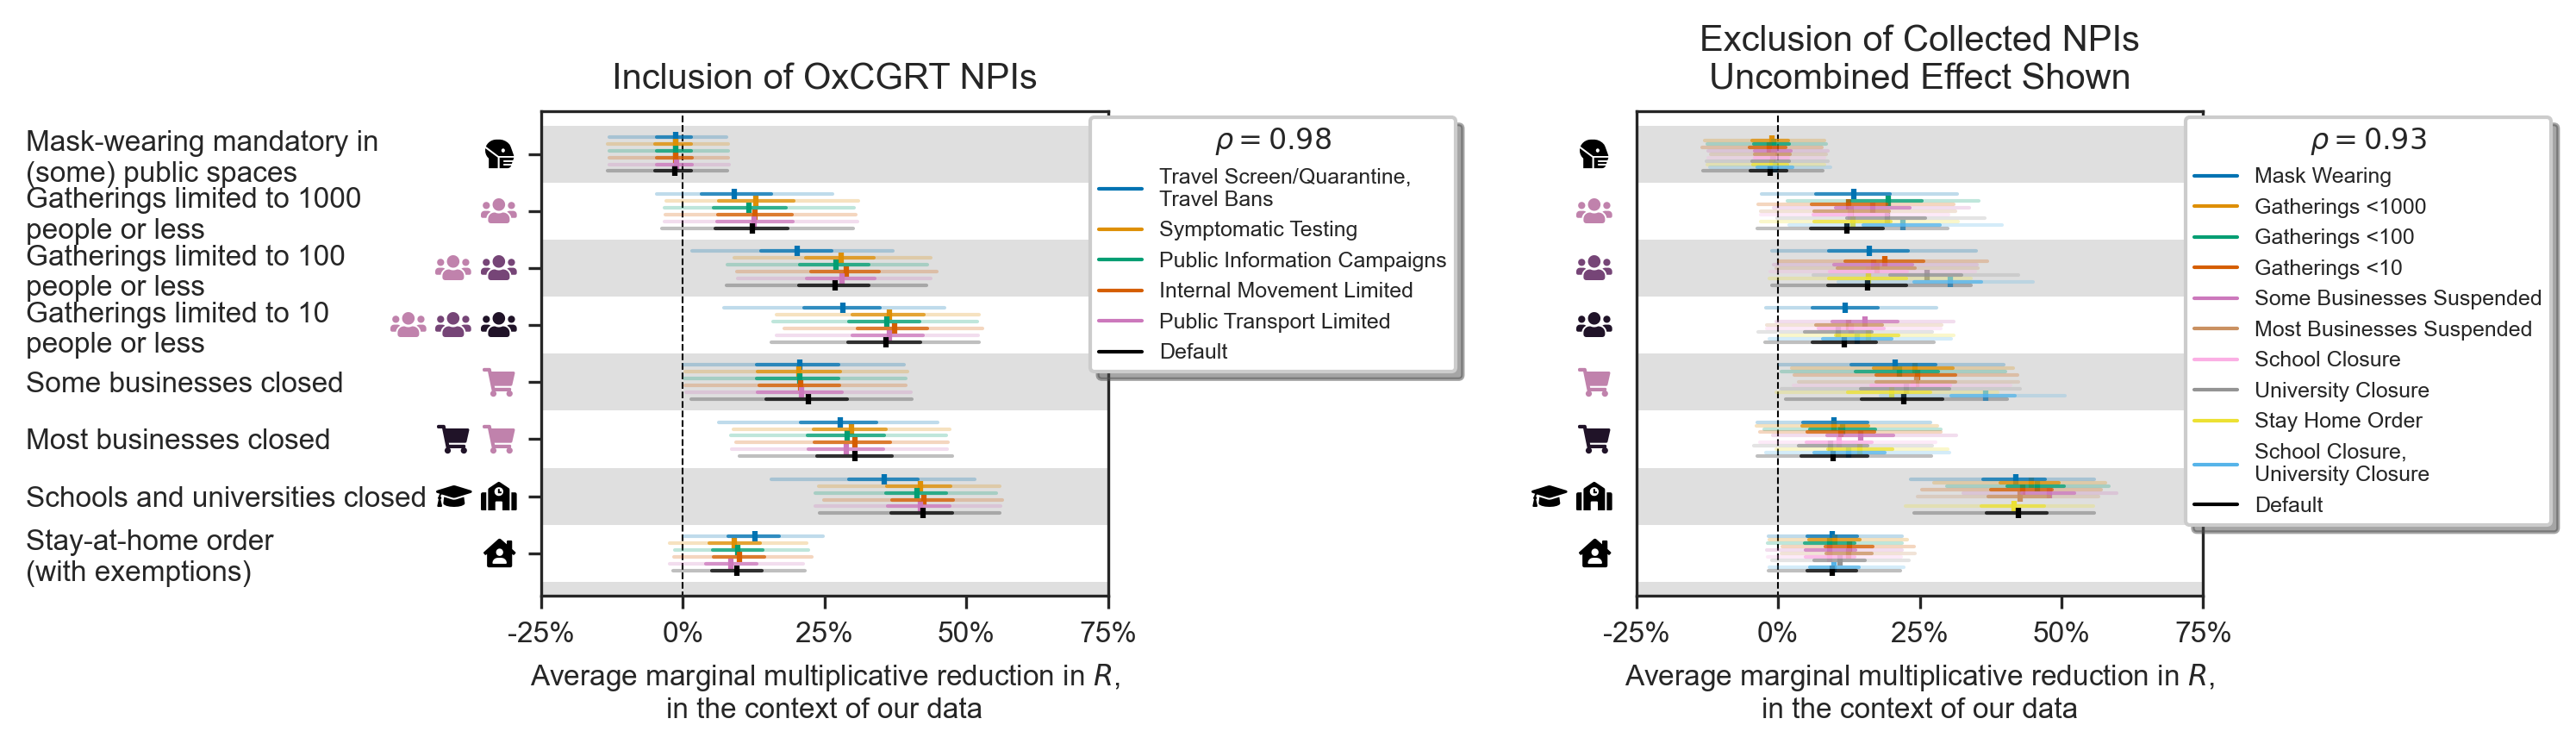

In [413]:
f;

# "Main" Figure

In [13]:
from matplotlib.gridspec import GridSpec

In [14]:
agg_holdout_trace = pickle.load(open('../../server/sensitivity_default/agg_holdout/results.pkl', 'rb'))

In [15]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_region_ends()
# and mask earlier if needed
data.mask_reopenings(n_extra=20, print_out=False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [16]:
fig = plt.figure(figsize=(11.5, 9), dpi=300)

gs = GridSpec(4, 4, figure=fig)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([10**-1, 10**7], [10**-1, 10**7], "--", linewidth=0.5, color="black")
for indx, region in enumerate(data.Rs):
    
    dd = np.nonzero(data.NewDeaths.mask[indx, :])[0][0]+19
    cd = np.nonzero(data.NewCases.mask[indx, :])[0][0]+19
    
    ed = agg_holdout_trace.ExpectedDeaths[:, indx, dd]
    ec = agg_holdout_trace.ExpectedCases[:, indx, cd]
    dist1 = pm.NegativeBinomial.dist(mu=ed , alpha=agg_holdout_trace.PsiDeaths)
    dist2 = pm.NegativeBinomial.dist(mu=ec , alpha=agg_holdout_trace.PsiCases)
    ec_output = dist2.random()
    try:
        ed_output = dist1.random()
    except:

        ed_output = 1e-10

    deaths = data.NewDeaths.data[indx, dd]
    cases = data.NewCases.data[indx, cd]
    if indx == 0:
        plt.scatter(cases, np.median(ec_output), color="tab:blue", label="Cases", s=12)    
        plt.scatter(deaths, np.median(ed_output), color="tab:red", label="Deaths", s=12)

    plt.scatter(cases, np.median(ec_output), color="tab:blue", s=12)
    plt.scatter(deaths, np.median(ed_output), color="tab:red", s=12)
    plt.plot([cases, cases], [np.percentile(ec_output, 2.5), np.percentile(ec_output, 97.5)], color="tab:blue", alpha=0.25, linewidth=2)
    plt.plot([deaths, deaths], [np.percentile(ed_output, 2.5), np.percentile(ed_output, 97.5)], color="tab:red", alpha=0.25, linewidth=2)

ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel("Reported", fontsize=10)
plt.ylabel("Predicted", fontsize=10)
plt.title(f"20 Day Extrapolation", fontsize=12)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left", fancybox=True, shadow=True, fontsize=10)

tick_vals = np.arange(6)-1
plt.xticks(np.power(10.0, tick_vals), [f"${np.power(10.0, loc):.0f}$" if loc<2 else f"$10^{loc}$"  for loc in tick_vals], fontsize=10)
plt.yticks(np.power(10.0, tick_vals), [f"${np.power(10.0, loc):.0f}$" if loc<2 else f"$10^{loc}$"  for loc in tick_vals], fontsize=10)
plt.grid(False, which='major', axis='both')

plt.xlim([10**-1, 10**4.5])
plt.ylim([10**-1, 10**4.5])
plt.minorticks_off()

rows = [2, 3, 2, 3]
cols = [0, 0, 1, 1]

folds = [['DE', 'HU', 'FI', 'IE', 'RS', 'BE'],
         ['DK', 'GR', 'NO', 'FR', 'RO', 'MA'],
         ['ES', 'CZ', 'NL', 'CH', 'PT', 'AT'],
         ['IL', 'SE', 'IT', 'MX', 'GB', 'PL']]

class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionLogR = trace.RegionLogR[:, indx]
        self.Z1C = trace.Z1C[:, indx, :]
        self.Z1D = trace.Z1D[:, indx, :]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
    
for s_i, (r,c) in enumerate(zip(rows, cols)):
    plt.subplot(gs.new_subplotspec((r, c), colspan=1, rowspan=1))
    
ax5 = plt.subplot(gs.new_subplotspec((0, 2), colspan=1, rowspan=1))
ax6 = plt.subplot(gs.new_subplotspec((0, 3), colspan=1, rowspan=1))
ax7 = plt.subplot(gs.new_subplotspec((1, 2), colspan=1, rowspan=1))
setup_small_plot(False, xlabel=False)


traces = load_tagged_traces(results_base_dir, "NPI_prior")
score = produce_score(default_res, traces)
y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 
plt.title("Effectiveness Prior", fontsize=8)
plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True, title=f'$\\rho={score:.2f}$', title_fontsize=8)


ax8 = plt.subplot(gs.new_subplotspec((1, 3), colspan=1, rowspan=1))
ax4 = plt.subplot(gs.new_subplotspec((2, 2), colspan=2, rowspan=2))
setup_larger_plot(False)

traces = [search_tagged_traces(results_base_dir, 'structural', 'cases'), search_tagged_traces(results_base_dir, 'structural', 'deaths')]
score = produce_score(default_res, traces)
y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width)         
          
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=10, title=f'$\\rho={score:.2f}$', title_fontsize=10)
plt.title("Data Source", fontsize=12)

plt.tight_layout()
plt.savefig(f"figs/validation/FigureMC.pdf", bbox_inches='tight')

Produced stored using [['Flaxman et. al.', 'Normal']]
Produced stored using [['Cases Only', 'Deaths Only']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


NameError: name 'f' is not defined

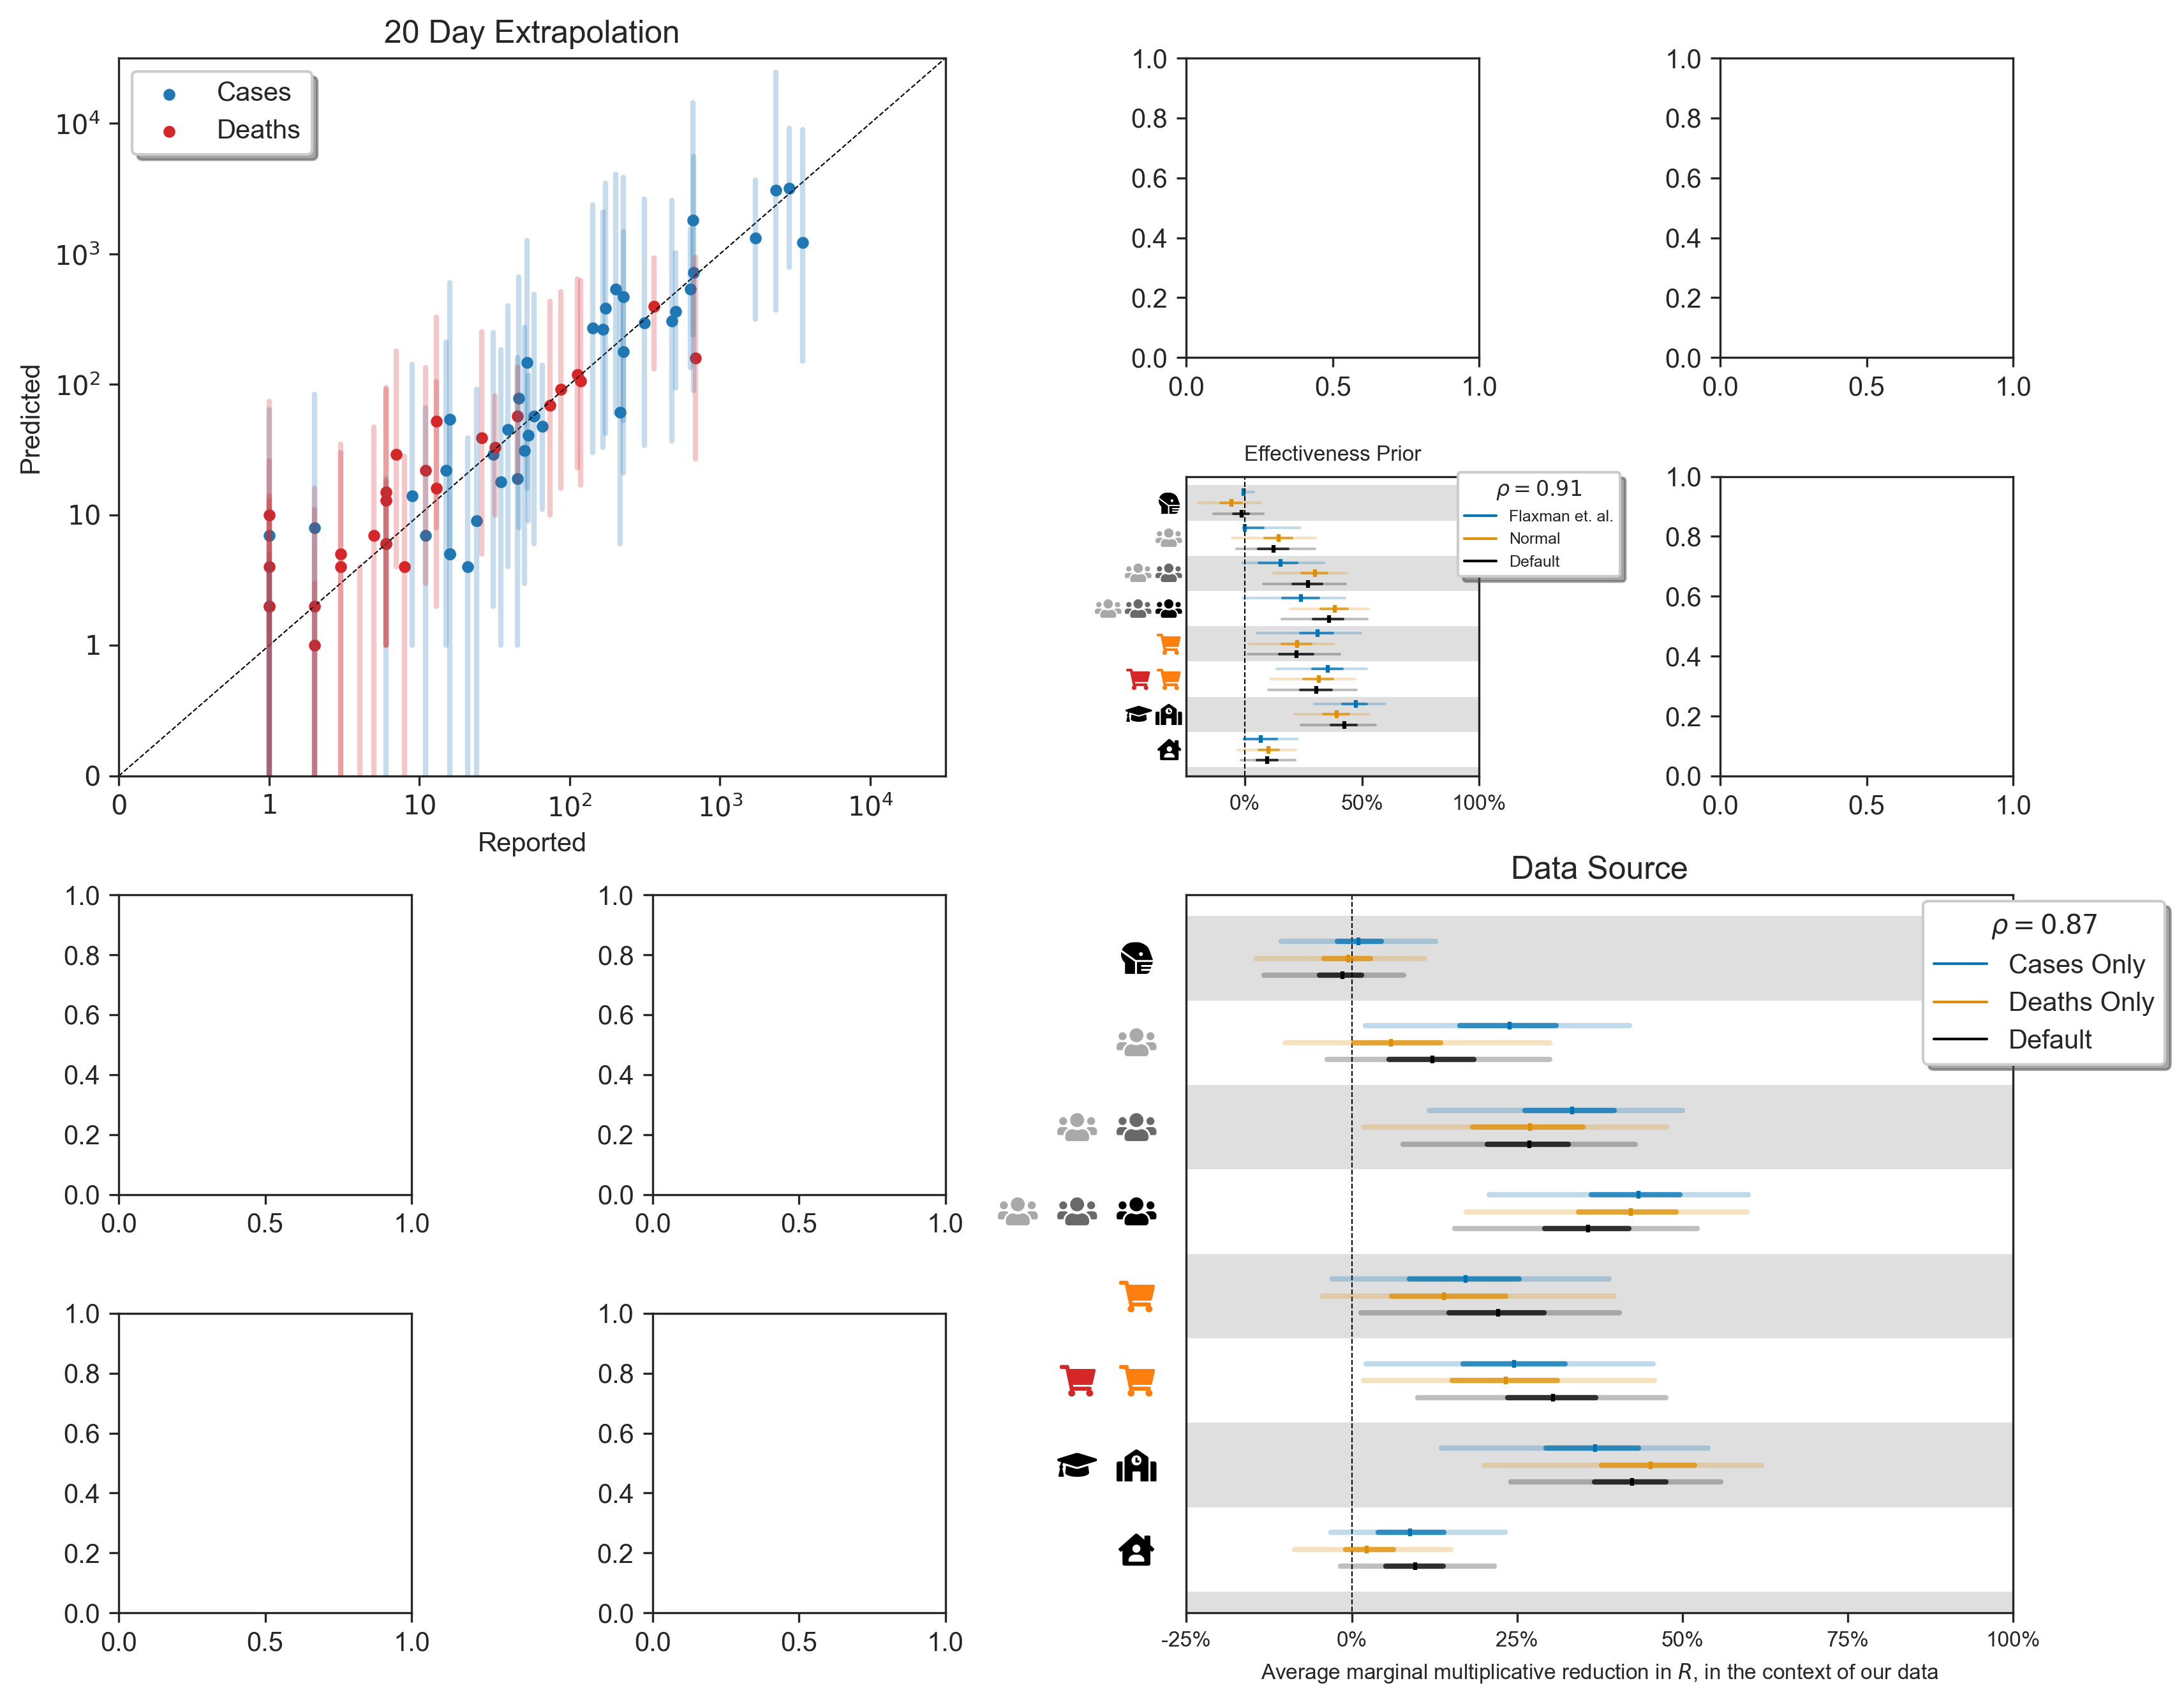

In [17]:
f;

# Growth Noise

Produced stored using [['0.4', '0.05', '0.3', '0.1']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


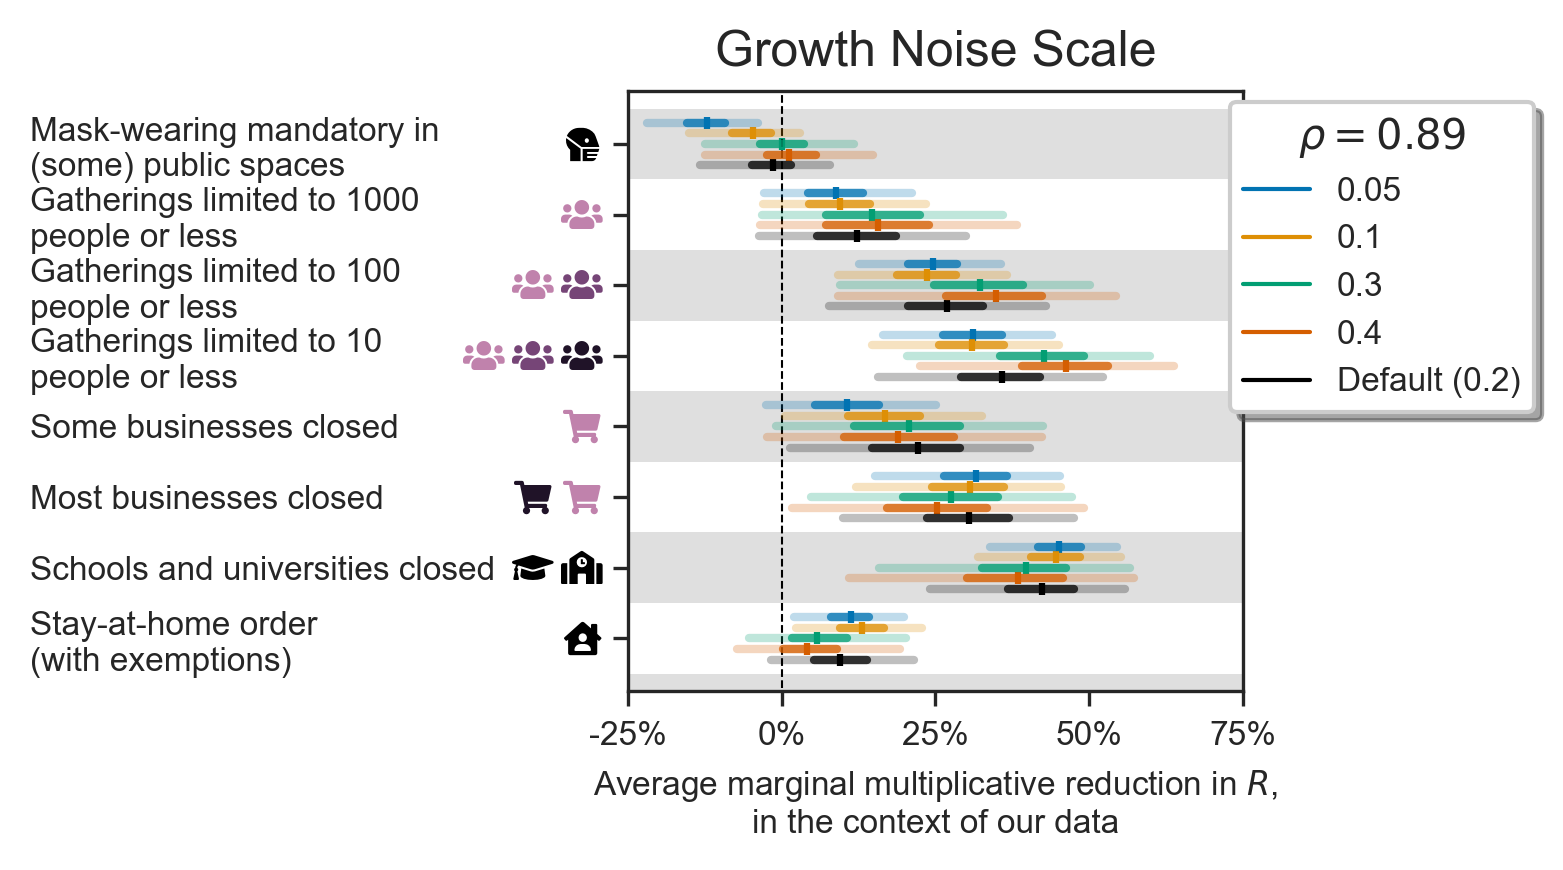

In [409]:
fig = plt.figure(figsize=(7, 3), dpi=300)
setup_large_plot()
traces = load_tagged_traces(results_base_dir, 'growth_noise')
score = produce_score(default_res, traces)

traces.sort(key= lambda x: float(x[1]))

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default (0.2)", 1, width)         
          
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.5, 1.01), fontsize=8, title=f'$\\rho={score:.2f}$', title_fontsize=10)
plt.title("Growth Noise Scale", fontsize=12)

plt.tight_layout()
plt.savefig(f"figs/validation/FigureGrowthNoise.pdf", bbox_inches='tight')

# data sensitivity

#### Data Type

Produced stored using [['Only Case Data', 'Only Death Data']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


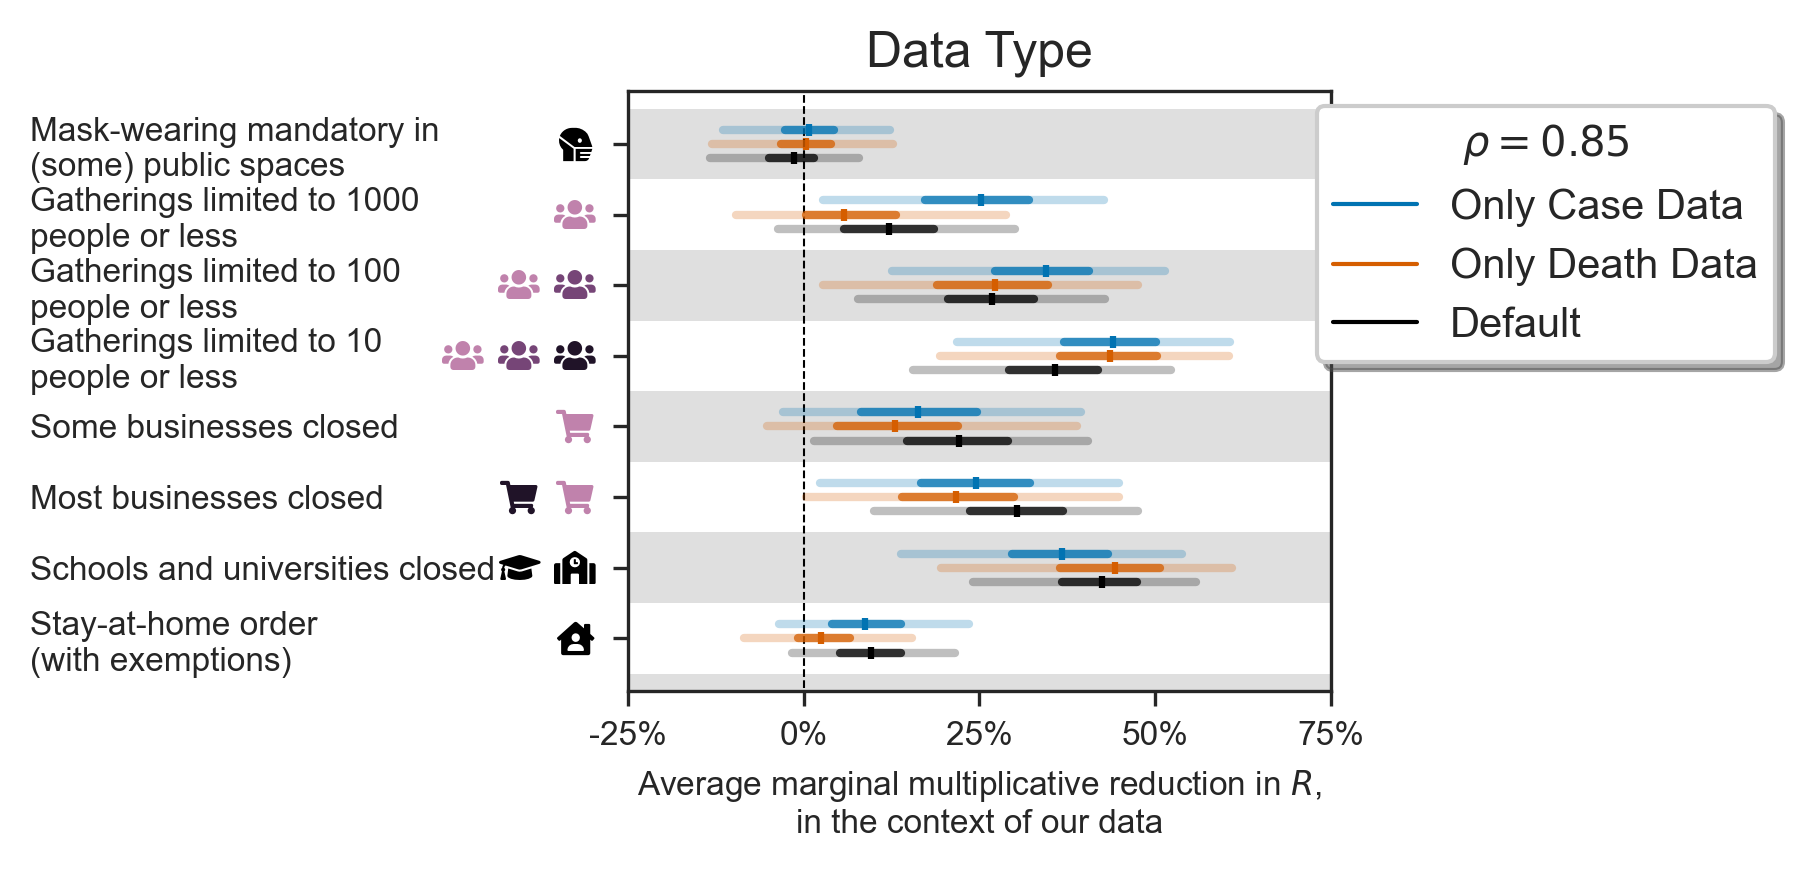

In [419]:
fig = plt.figure(figsize=(6, 3), dpi=300)
setup_large_plot()
traces = [search_tagged_traces(results_base_dir, 'structural', 'cases'), search_tagged_traces(results_base_dir, 'structural', 'deaths')]
score = produce_score(default_res, traces)
y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
colors_h = [colors[0], colors[3]]
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace, y_off[i], colors_h[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width)         
          
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=10, title=f'$\\rho={score:.2f}$', title_fontsize=10)
plt.title("Data Type", fontsize=12)

plt.tight_layout()
plt.savefig(f"figs/validation/FigureDataType.pdf", bbox_inches='tight')

#### Country Sensitivity

No handles with labels found to put in legend.


Produced stored using [['RS', 'PL', 'GE', 'GR', 'DK', 'IL', 'GB', 'SG', 'FR', 'SE', 'LV', 'AD', 'LT', 'CZ', 'MT', 'NO', 'CH', 'MA', 'NZ', 'NL', 'AT', 'BA', 'MY', 'MX', 'AL', 'BE', 'BG', 'ZA', 'FI', 'EE', 'HU', 'SI', 'ES', 'IE', 'SK', 'RO', 'IS', 'PT', 'HR', 'IT', 'DE']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


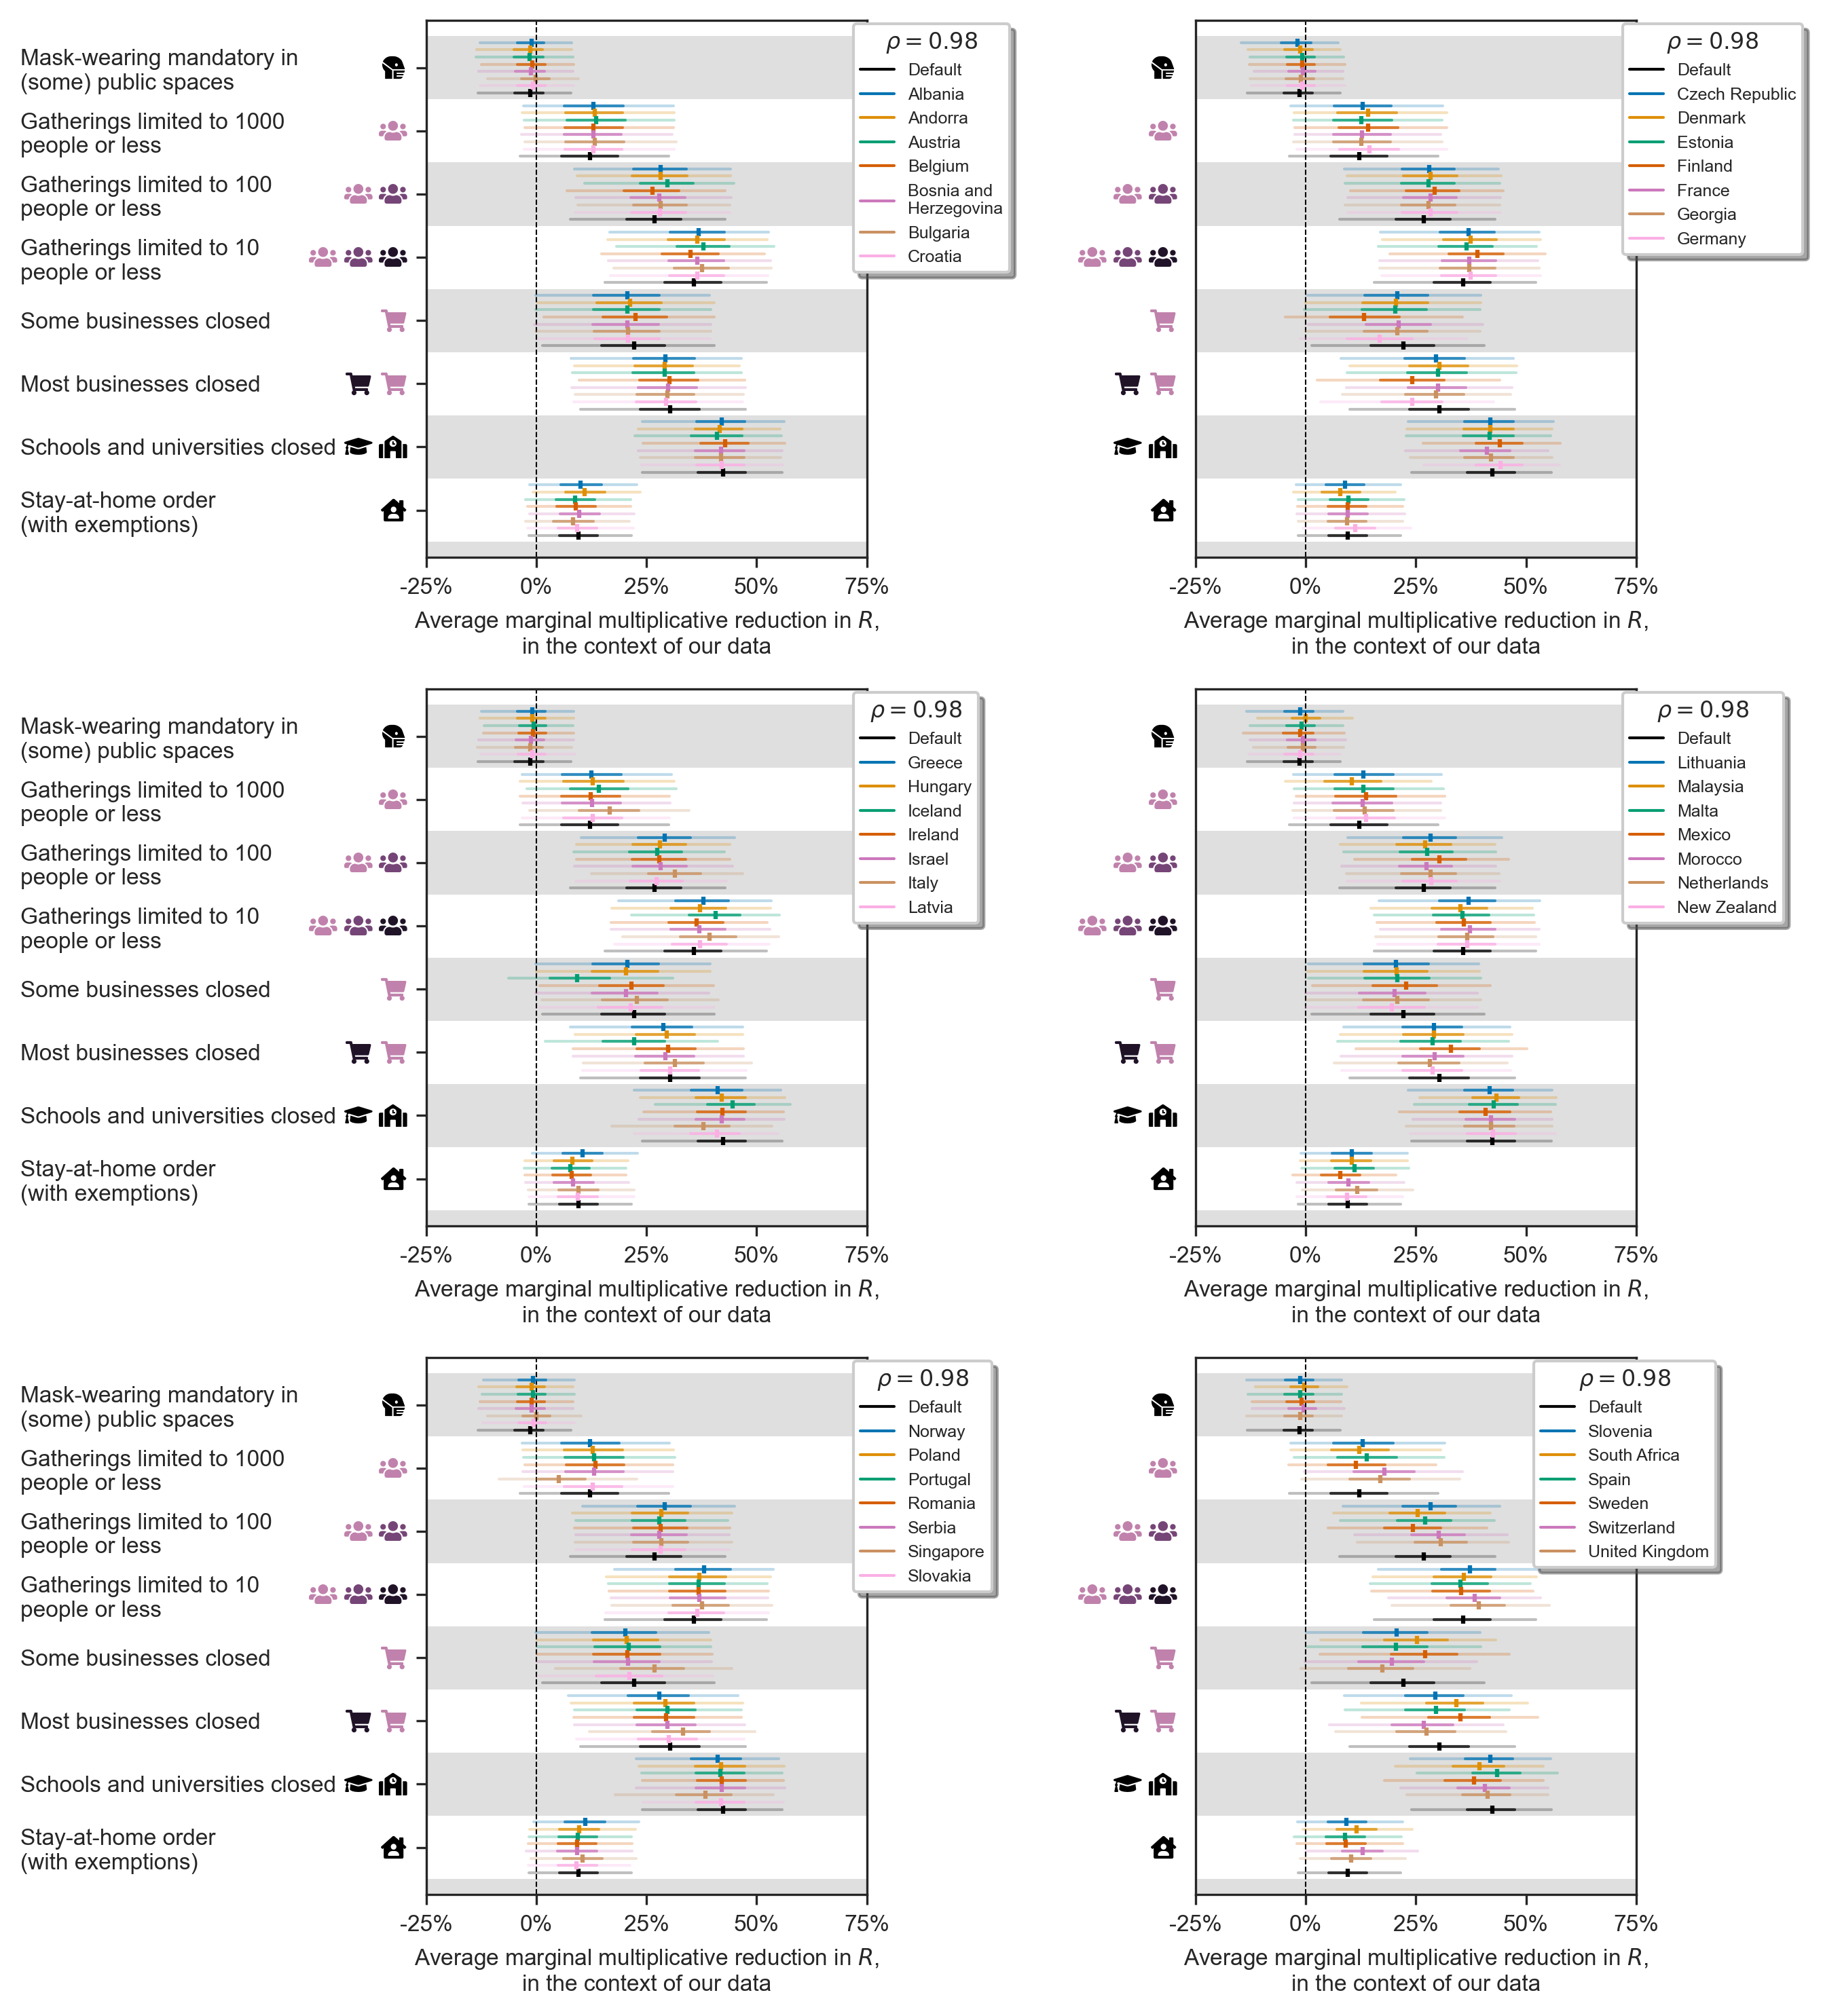

In [421]:
fig = plt.figure(figsize=(9, 10), dpi=300)

traces = load_tagged_traces(results_base_dir, 'region_holdout')
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.4, 0.4, 8)
for r_i, r in enumerate(data.Rs):
    r_i_p = r_i % 7 
    if r_i_p == 0:
        plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
        plt.subplot(3, 2, int(r_i/7) + 1)
        if (int(r_i/7) + 1) == 1 or (int(r_i/7) + 1) == 3 or (int(r_i/7) + 1) == 5:
            setup_large_plot()
        else:
            setup_large_plot(False)
        add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, 1)
    trace, _ = search_tagged_traces(results_base_dir, 'region_holdout', r)
    label = data.RNames[r][0]
    if 'and' in label and 'Bosnia' in label:
        label = 'Bosnia and\nHerzegovina'
    add_trace_to_plot(trace, y_off[r_i_p], colors[r_i_p], label, 1, 1)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.tight_layout()
plt.savefig(f"figs/validation/FigDC.pdf", bbox_inches='tight')

#### Thresholds

Produced stored using [['300', '50', '200', '10']]
Produced stored using [['50', '30', '5', '1']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


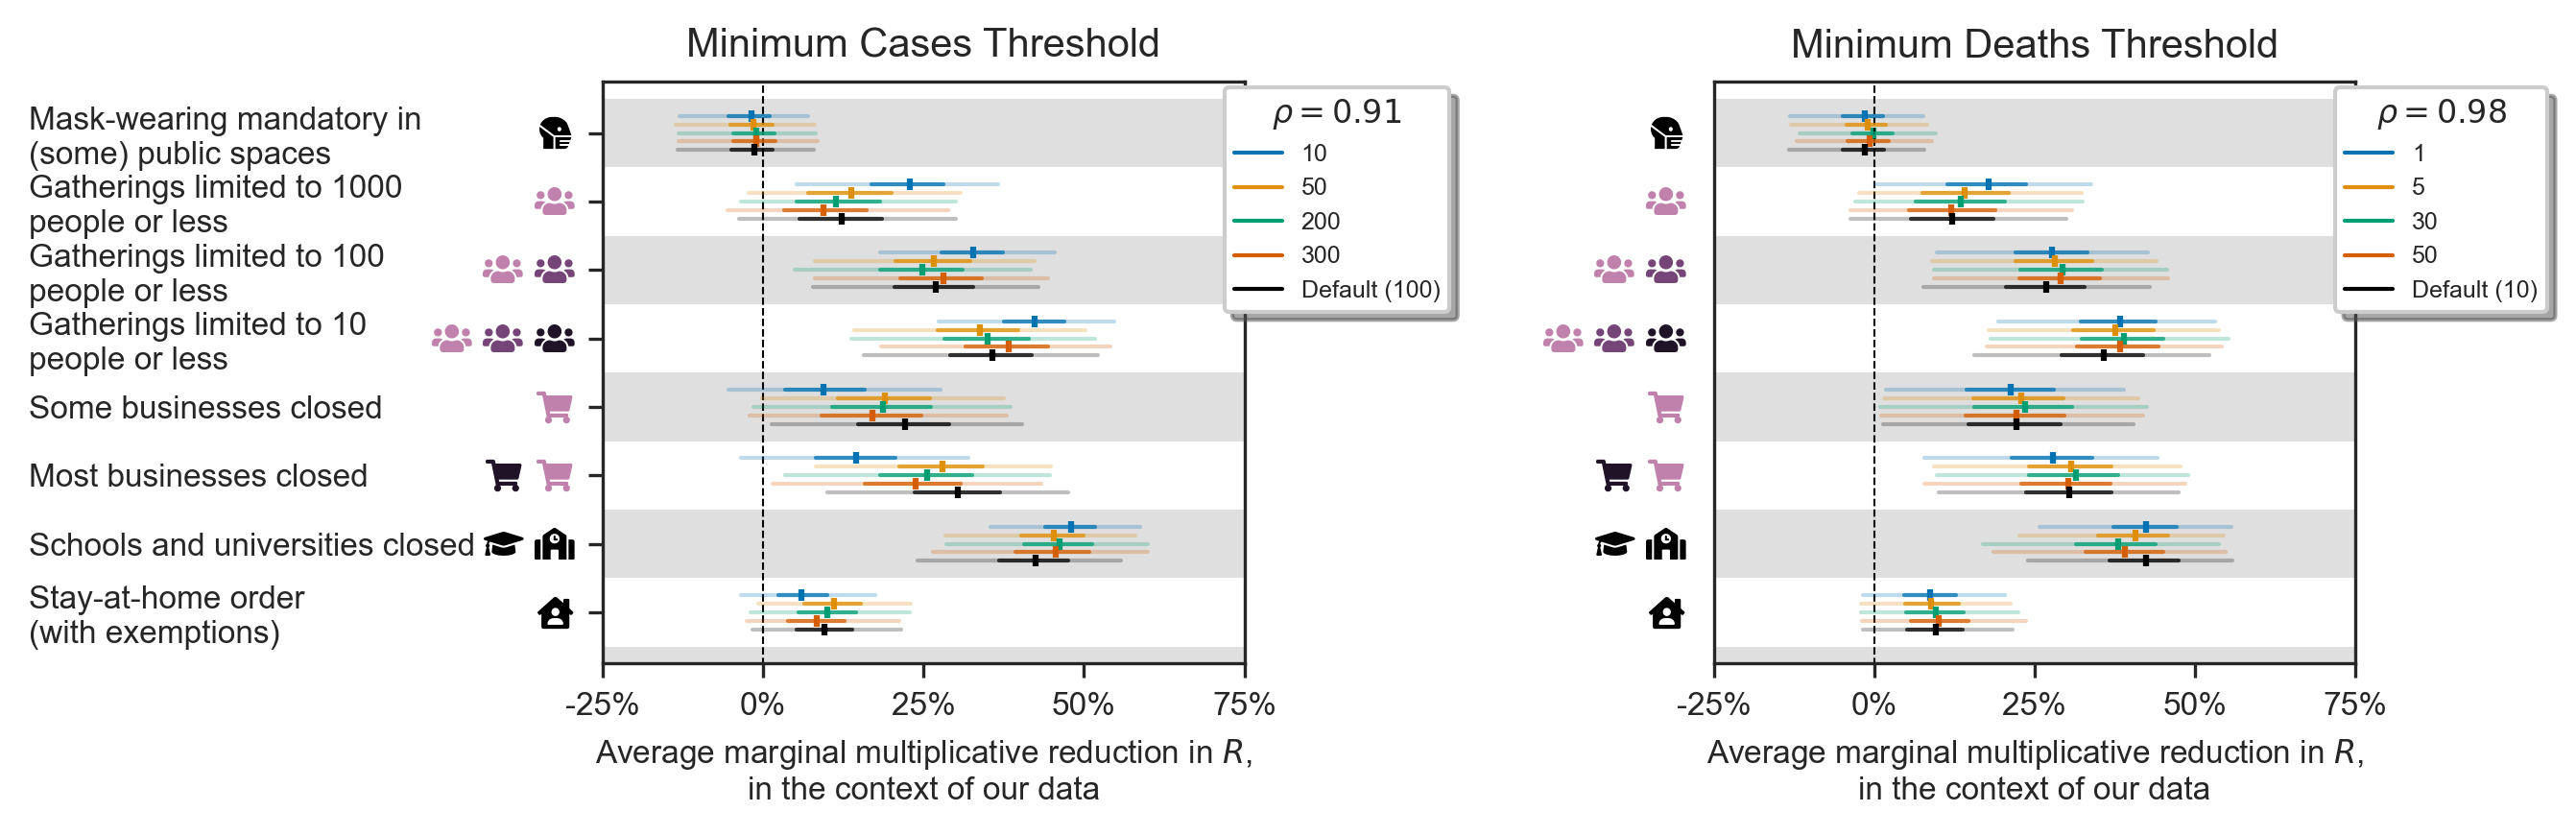

In [425]:
fig = plt.figure(figsize=(9, 3), dpi=300)

plt.subplot(121)
setup_large_plot()

traces = load_tagged_traces(results_base_dir, "cases_threshold")
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
traces.sort(key= lambda x: int(x[1]))
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default (100)", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Minimum Cases Threshold", fontsize="10")

plt.subplot(122)
setup_large_plot(False, True, True)
traces = load_tagged_traces(results_base_dir, "deaths_threshold")
score = produce_score(default_res, traces)

traces.sort(key= lambda x: int(x[1]))

y_off = -np.linspace(-0.25, 0.25, len(traces)+1)
width = 1
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default (10)", 1, width) 
    
plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Minimum Deaths Threshold", fontsize="10")
plt.tight_layout()
plt.savefig(f"figs/validation/FigureThresholds.pdf", bbox_inches='tight')

# NPI Timing

In [434]:
fig = plt.figure(figsize=(8, 3), dpi=300)
plt.subplot(121)
setup_large_plot()

derived_features = derived_features_comb
traces = [*load_tagged_traces(results_base_dir, "any_npi_active"), *load_tagged_traces(results_base_dir, "delay_schools")]
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("NPI Timing: Miscellaneous", fontsize="10")

plt.subplot(122)
setup_large_plot(False, False, True)

traces = load_tagged_traces(results_base_dir, "npi_timing")
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.3, 0.3, len(traces)+1)
width = 2

derived_features = [("", [i]) for i in range(9)]
add_trace_to_plot(traces[0][0], 0, 'k', '', 1, width)
plt.ylim([-8.75, 0.75])
ytick_locs = np.arange(0, 9)
plt.yticks(-ytick_locs, [f"NPI {(y+1):d}" for y in ytick_locs], fontsize=8)

derived_features = derived_features_comb
    
plt.title("NPI Timing: Order", fontsize="10")
plt.tight_layout()
plt.savefig(f"figs/validation/FigureNPITiming.pdf", bbox_inches='tight')

Produced stored using [['Bonus Any-Active NPI', 'School & University\nClosure Delayed']]
Produced stored using [['npi_timing - result.txt']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


(8000, 9)

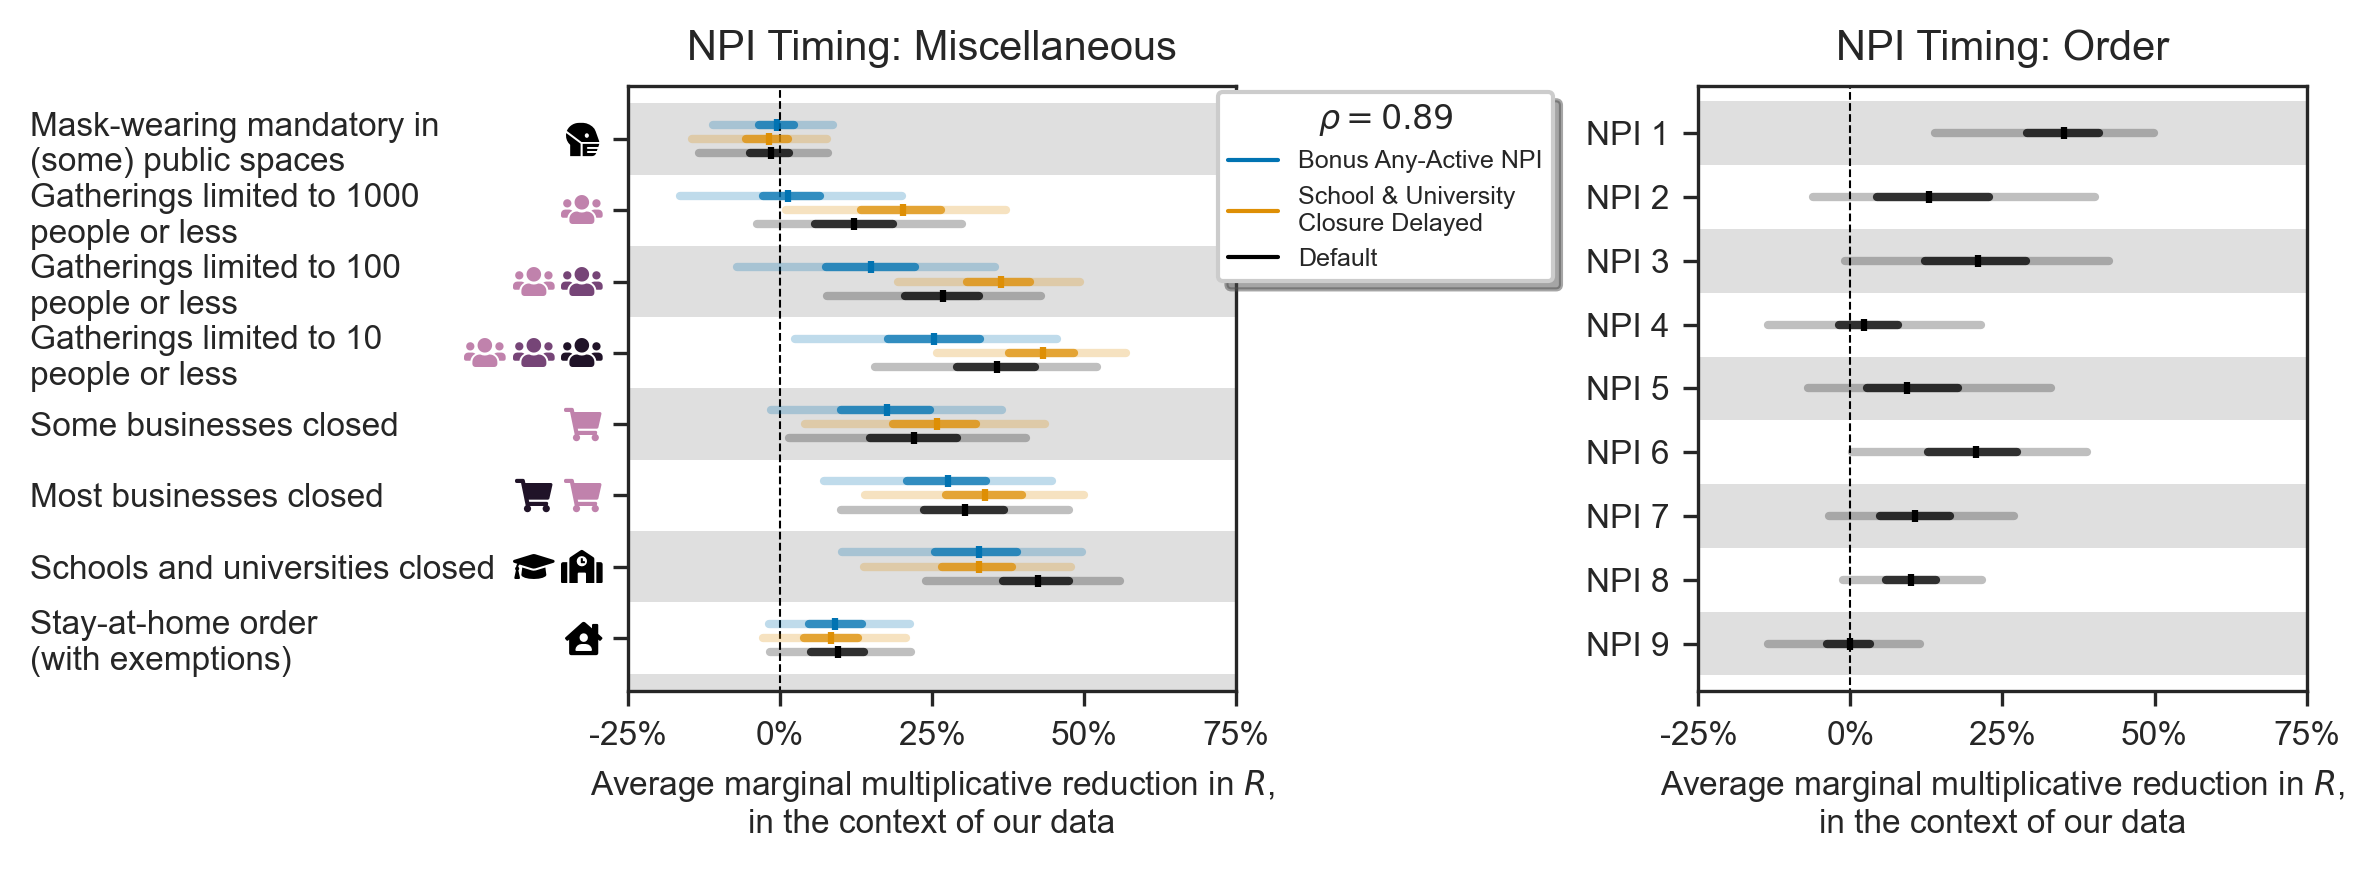

In [435]:
traces[0][0].shape

# Iceland, Sweden Plot

In [436]:
plt.figure(figsize=(4,3), dpi=300)

derived_features = [
 ("Schools closed", [6]),
 ("Universities closed", [7]),
 ("Schools and univerisities closed", [6, 7]),
 ]

nF = len(derived_features)

ax = plt.gca()
x_min = -25
x_max = 100
plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nF+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]

plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=150)

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nF - 0.25), 0.75])

for cm in range(len(derived_features)):
    for i, val in enumerate(derived_features[cm][1]):
        plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 

plt.xlabel("Average marginal multiplicative reduction in $R$,\nin the context of our data", fontsize=8)


iceland = search_tagged_traces(results_base_dir, 'region_holdout', 'IS')[0]
sweden = search_tagged_traces(results_base_dir, 'region_holdout', 'SE')[0]
y_off = -np.linspace(-0.2, 0.2, 3)
add_trace_to_plot(iceland, y_off[0], colors[0], "Iceland Excluded", 1, 2)
add_trace_to_plot(sweden, y_off[1], colors[1], "Sweden Excluded", 1, 2)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, 2)
plt.legend(shadow=True, fancybox=True, fontsize=6)
plt.title("Schools and Universities Sensitivity", fontsize=10)
plt.savefig(f"figs/validation/FigISSE.pdf", bbox_inches='tight')

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


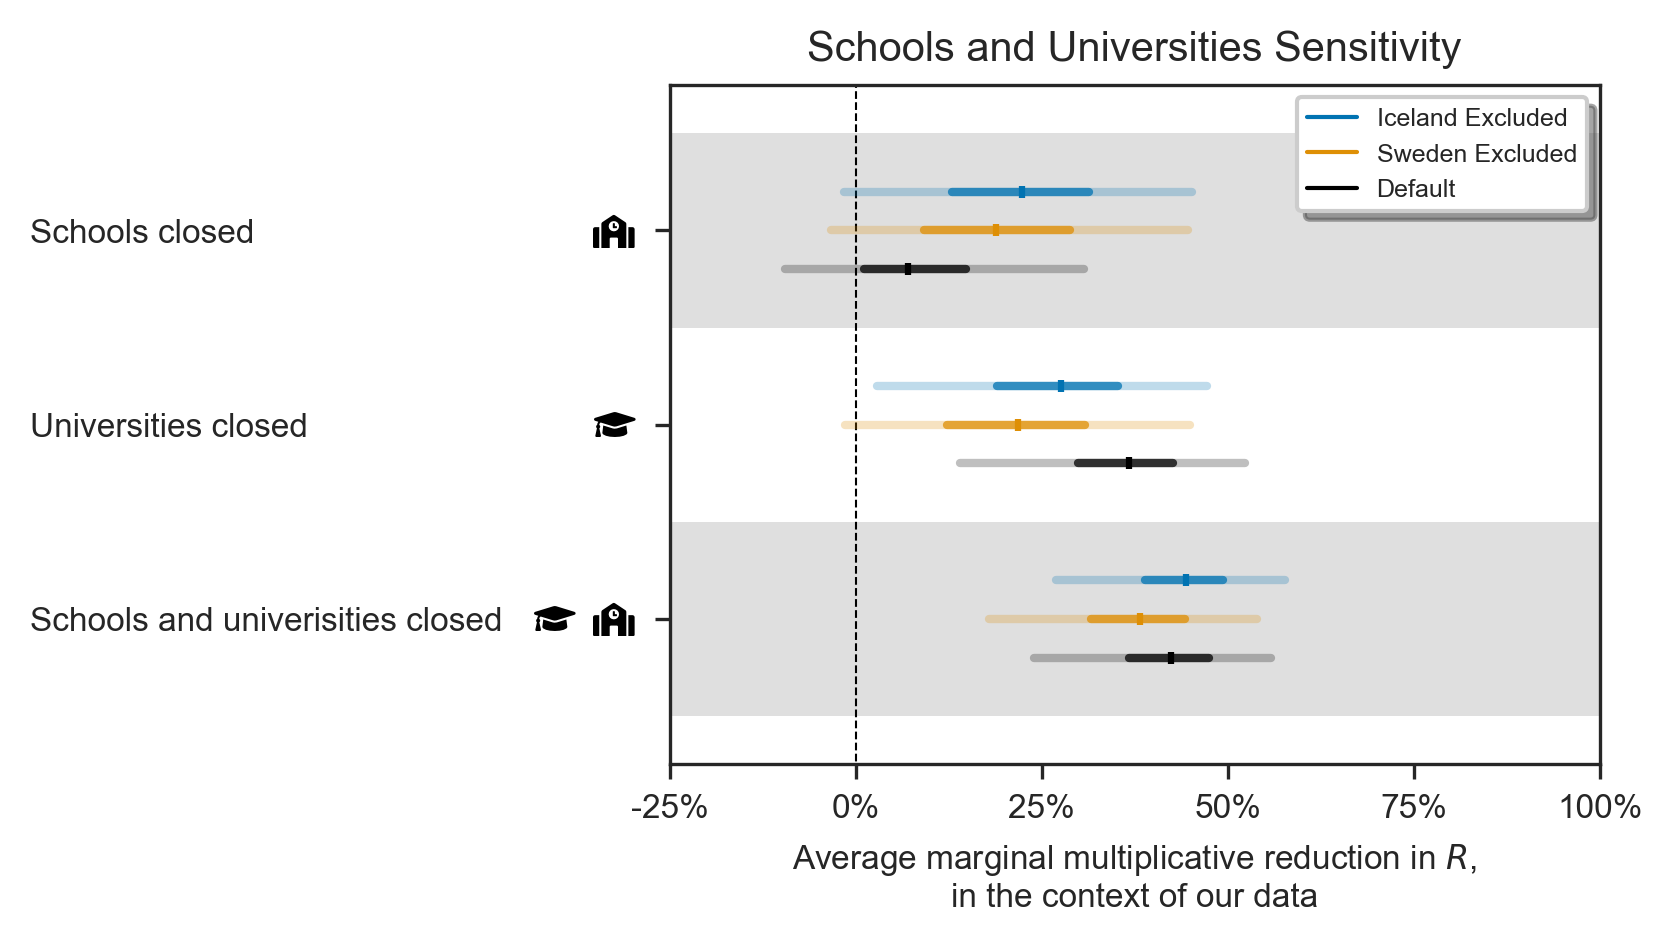

In [437]:
f;

# Ascertainment Rate

In [22]:
traces

[[array([[-0.05673553,  0.15397897,  0.23318272, ...,  0.23781912,
           0.40276484,  0.07180164],
         [-0.023273  ,  0.08078899,  0.43426298, ...,  0.17188218,
           0.28575398,  0.07895697],
         [-0.03741182,  0.03503061,  0.40484029, ...,  0.37080165,
           0.29758499,  0.0426486 ],
         ...,
         [-0.02498371,  0.11045614,  0.3264879 , ...,  0.07987965,
           0.40933594,  0.03970903],
         [-0.01650302, -0.00295376,  0.50407976, ...,  0.12614005,
           0.42822354,  0.06142484],
         [-0.02618274,  0.22246468,  0.27174175, ...,  0.2546222 ,
           0.22312551,  0.10125395]]),
  'ascertainment_rate - nonsynth_adjusted_variable_CM_Alpha.txt'],
 [array([[-0.02940919,  0.22570224,  0.30091613, ...,  0.1461082 ,
           0.31036013,  0.1267833 ],
         [ 0.04991106,  0.26786043,  0.12505826, ...,  0.20656114,
           0.13850542,  0.10101069],
         [ 0.02568332,  0.3425553 ,  0.15260031, ...,  0.23838654,
           0.01223

Produced stored using [['ascertainment_rate - nonsynth_adjusted_variable_CM_Alpha.txt', 'ascertainment_rate - nonsynth_adjusted_simple_CM_Alpha.txt']]


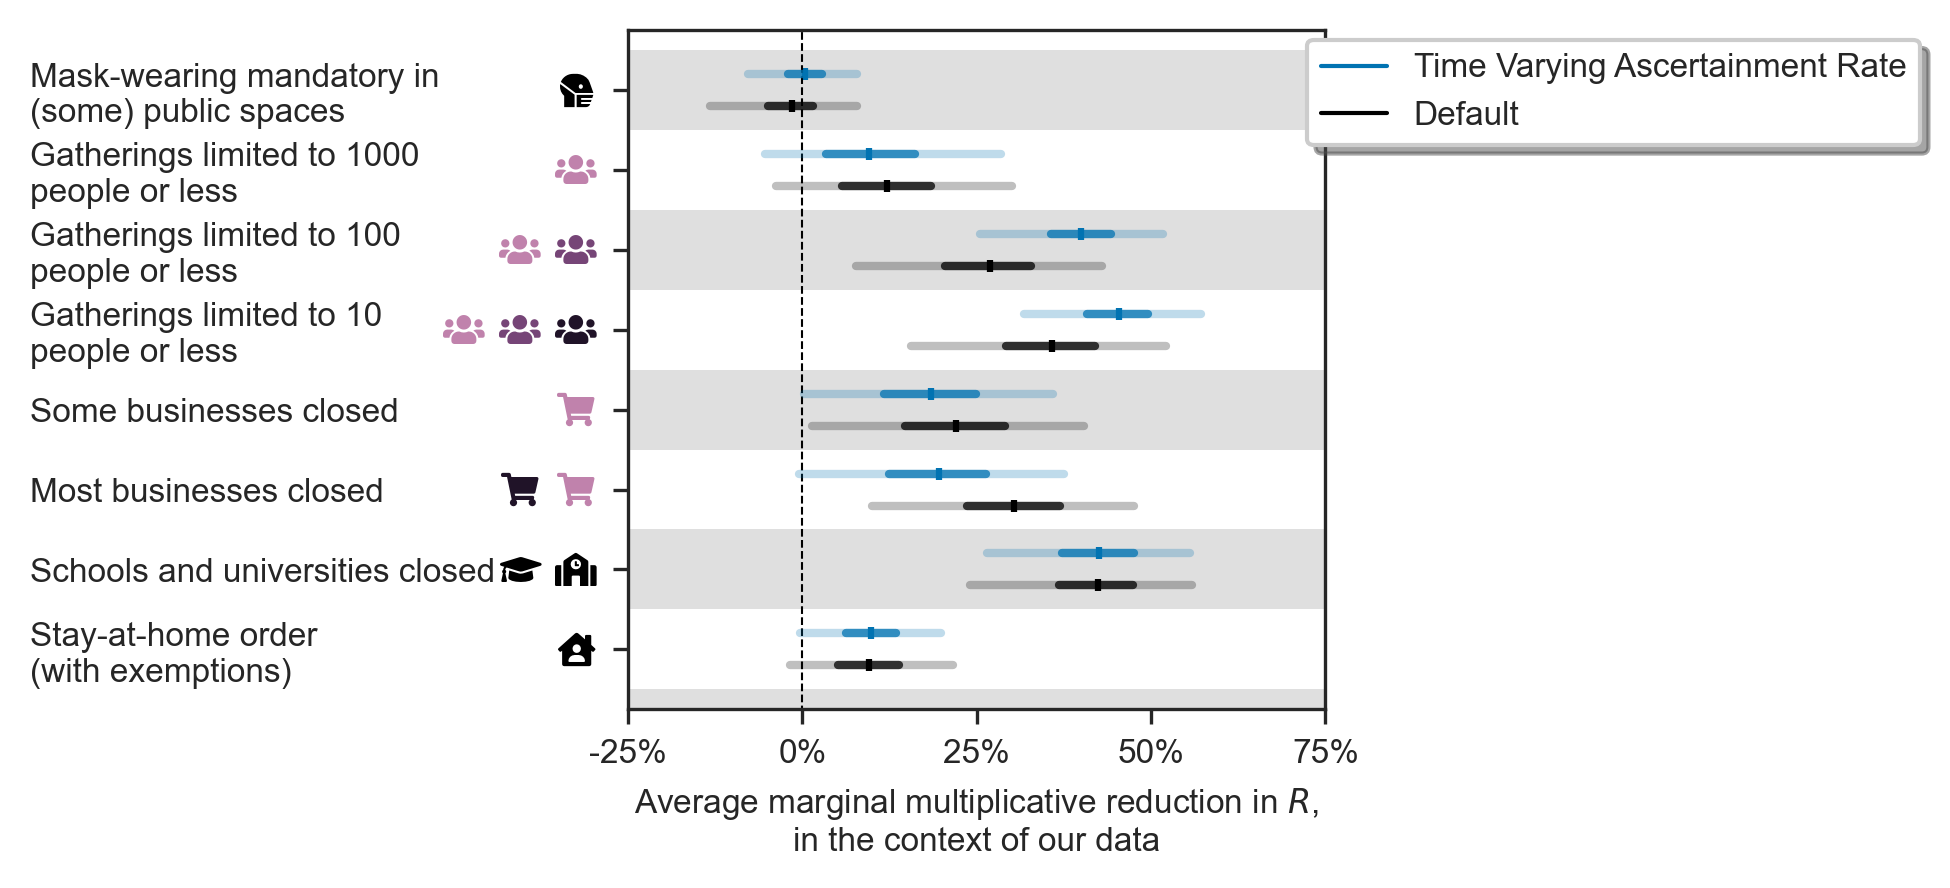

In [25]:
fig = plt.figure(figsize=(3, 3), dpi=300)

setup_large_plot()
derived_features = derived_features_comb
traces = load_tagged_traces(results_base_dir, "ascertainment_rate")
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 2

add_trace_to_plot(np.exp(-traces[0][0][:, :9]), y_off[i], colors[i], 'Time Varying Ascertainment Rate', 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=8)

Produced stored using [['ascertainment_rate - nonsynth_adjusted_variable_CM_Alpha.txt', 'ascertainment_rate - nonsynth_adjusted_simple_CM_Alpha.txt']]


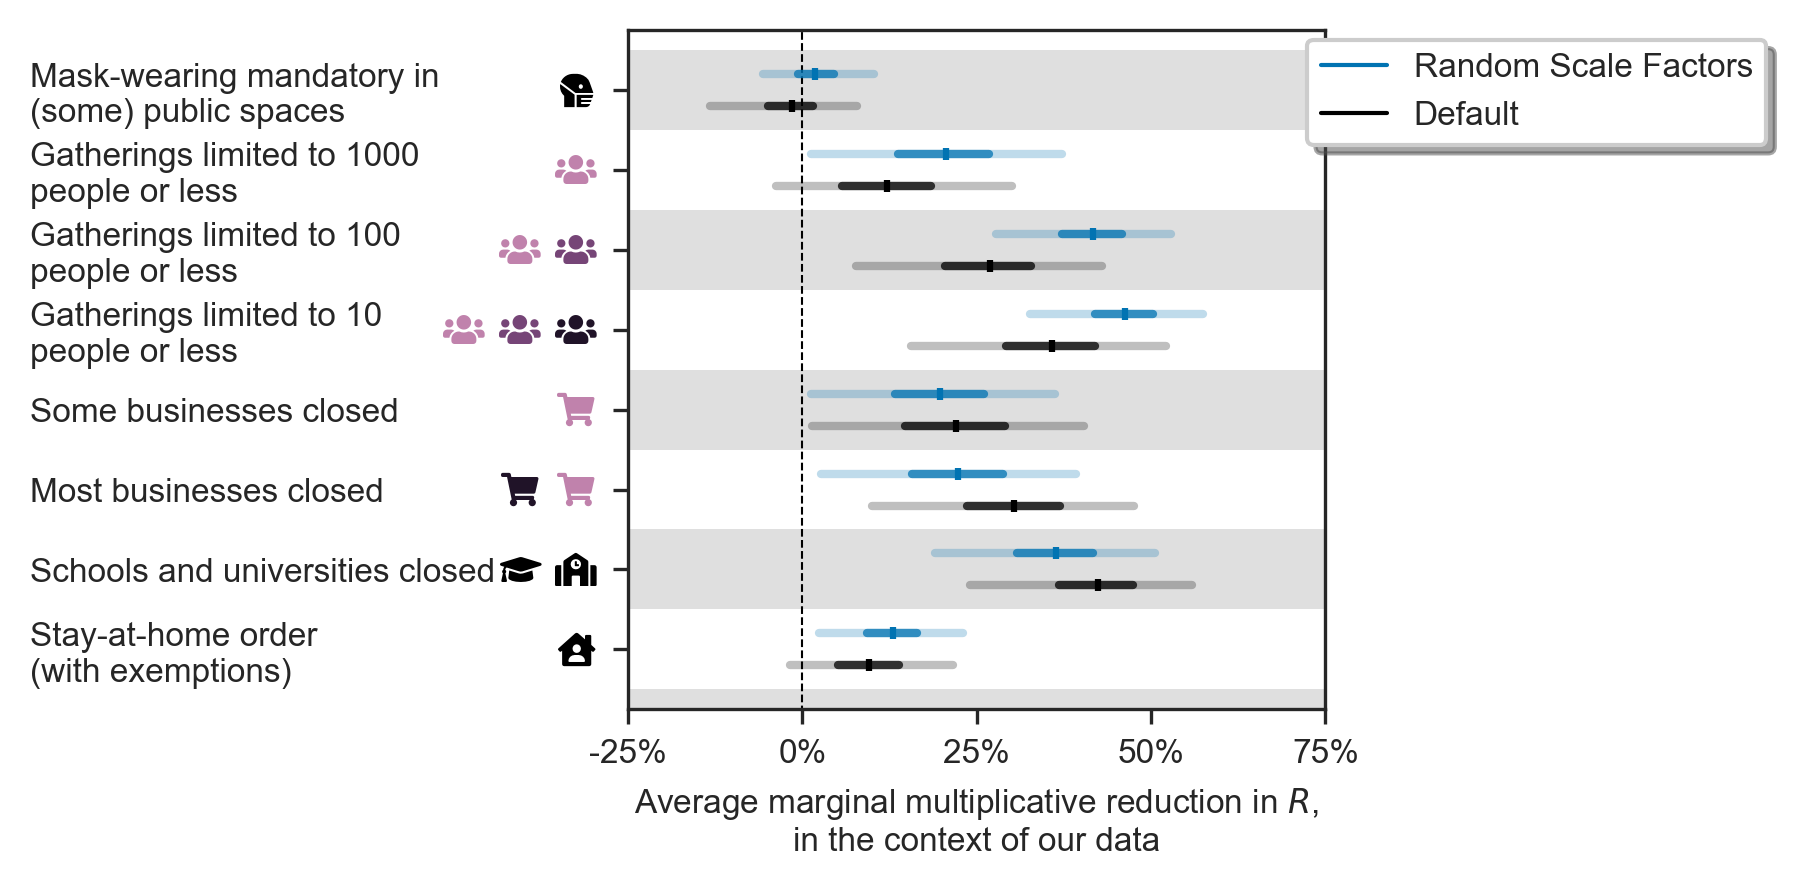

In [27]:
fig = plt.figure(figsize=(3, 3), dpi=300)

setup_large_plot()
derived_features = derived_features_comb
traces = load_tagged_traces(results_base_dir, "ascertainment_rate")
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 2

add_trace_to_plot(np.exp(-traces[1][0][:, :9]), y_off[i], colors[i], 'Random Scale Factors', 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=8)

# Global Sensitivity

In [457]:
derived_features = derived_features_comb

In [461]:
def fname_to_params(fname):
    gi = float(re.search(r"(gi_mean_mean)-(\d*.\d*)", fname).groups()[1])
    cd = float(re.search(r"(cases_mean_mean)-(\d*.\d*)", fname).groups()[1])
    dd = float(re.search(r"(deaths_mean_mean)-(\d*.\d*)", fname).groups()[1])
    
    return gi, cd, dd

def load_tagged_traces_gs(result_base_dir, tag):
    path = os.path.join(results_base_dir, tag)
    
    all_traces = []
    for filedir, _, files in os.walk(path):
        for f in files:
            if '.txt' in f:
                try:
                    trace = np.loadtxt(os.path.join(filedir, f))
                    
                    nS, _ = trace.shape
                    nF = len(derived_features)
                    derived_samples = np.zeros((nS, nF))

                    for f_i, (_, prodrows) in enumerate(derived_features):
                        samples = np.ones(nS)
                        for r in prodrows:
                            samples = samples * trace[:, r] 
                        derived_samples[:, f_i] = samples

                    res = derived_samples
                    median = np.median(res, axis=0)
                    
                    gi, cd, dd = fname_to_params(f)
                    
                    all_traces.append([median, gi, cd, dd, trace])
                    print(f'{len(all_traces)} Exps')
                except Exception as e:
                    print(e)
                    
    return all_traces

In [463]:
global_traces = load_tagged_traces_gs(results_base_dir, 'epiparam_prior_extra')

1 Exps
2 Exps
3 Exps
4 Exps
5 Exps
6 Exps
7 Exps
8 Exps
9 Exps
10 Exps
11 Exps
12 Exps
13 Exps
14 Exps
15 Exps
16 Exps
17 Exps
18 Exps
19 Exps
20 Exps
21 Exps
22 Exps
23 Exps
24 Exps
25 Exps
26 Exps
27 Exps
28 Exps
29 Exps
30 Exps
31 Exps
32 Exps
33 Exps
34 Exps
35 Exps
36 Exps
37 Exps
38 Exps
39 Exps
40 Exps
41 Exps
42 Exps
43 Exps
44 Exps
45 Exps
46 Exps
47 Exps
48 Exps
49 Exps
50 Exps
51 Exps
52 Exps
53 Exps
54 Exps
55 Exps
56 Exps
57 Exps
58 Exps
59 Exps
60 Exps
61 Exps
62 Exps
63 Exps
64 Exps
65 Exps
66 Exps
67 Exps
68 Exps
69 Exps
70 Exps
71 Exps
72 Exps
73 Exps
74 Exps
75 Exps
76 Exps
77 Exps
78 Exps
79 Exps
80 Exps
81 Exps
82 Exps
83 Exps
84 Exps
85 Exps
86 Exps
87 Exps
88 Exps
89 Exps
90 Exps
91 Exps
92 Exps
93 Exps
94 Exps
95 Exps
96 Exps
97 Exps
98 Exps
99 Exps
100 Exps
101 Exps
102 Exps
103 Exps
104 Exps
105 Exps
106 Exps
107 Exps
108 Exps
109 Exps
110 Exps
111 Exps
112 Exps
113 Exps
114 Exps
115 Exps
116 Exps


In [464]:
medians, gis, cds, dds, full_traces = list(zip(*global_traces))

In [469]:
nS, _ = default_res.shape
nF = len(derived_features)
derived_samples = np.zeros((nS, nF))

for f_i, (_, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * default_res[:, r] 
    derived_samples[:, f_i] = samples
    
default_median = np.median(derived_samples, axis=0)

In [470]:
unique_gis = np.unique(gis)
unique_cds = np.unique(cds)
unique_dds = np.unique(dds)

In [471]:
def gi_to_grid(cm, global_traces, unique_cds, unique_dds, gi, default_median):
    filtered_traces = list(filter(lambda t: t[1] == gi, global_traces))
    
    grid = np.zeros((len(unique_cds), len(unique_dds)))
    grid[:] = np.nan
    
    for meds, _, cd, dd, _ in filtered_traces:
        cd_ind = np.where(unique_cds == cd)
        dd_ind = np.where(unique_dds == dd)
        val = 100*(-meds[cm] + default_median[cm]) 
        grid[cd_ind, dd_ind] = val
    
    return grid

In [472]:
short_names = ['Mask Wearing', 'Gatherings <1000', 'Gatherings <100', 'Gatherings <10', 'Some Buss', 'Most Buss', 'Educat', 'Stay Home']

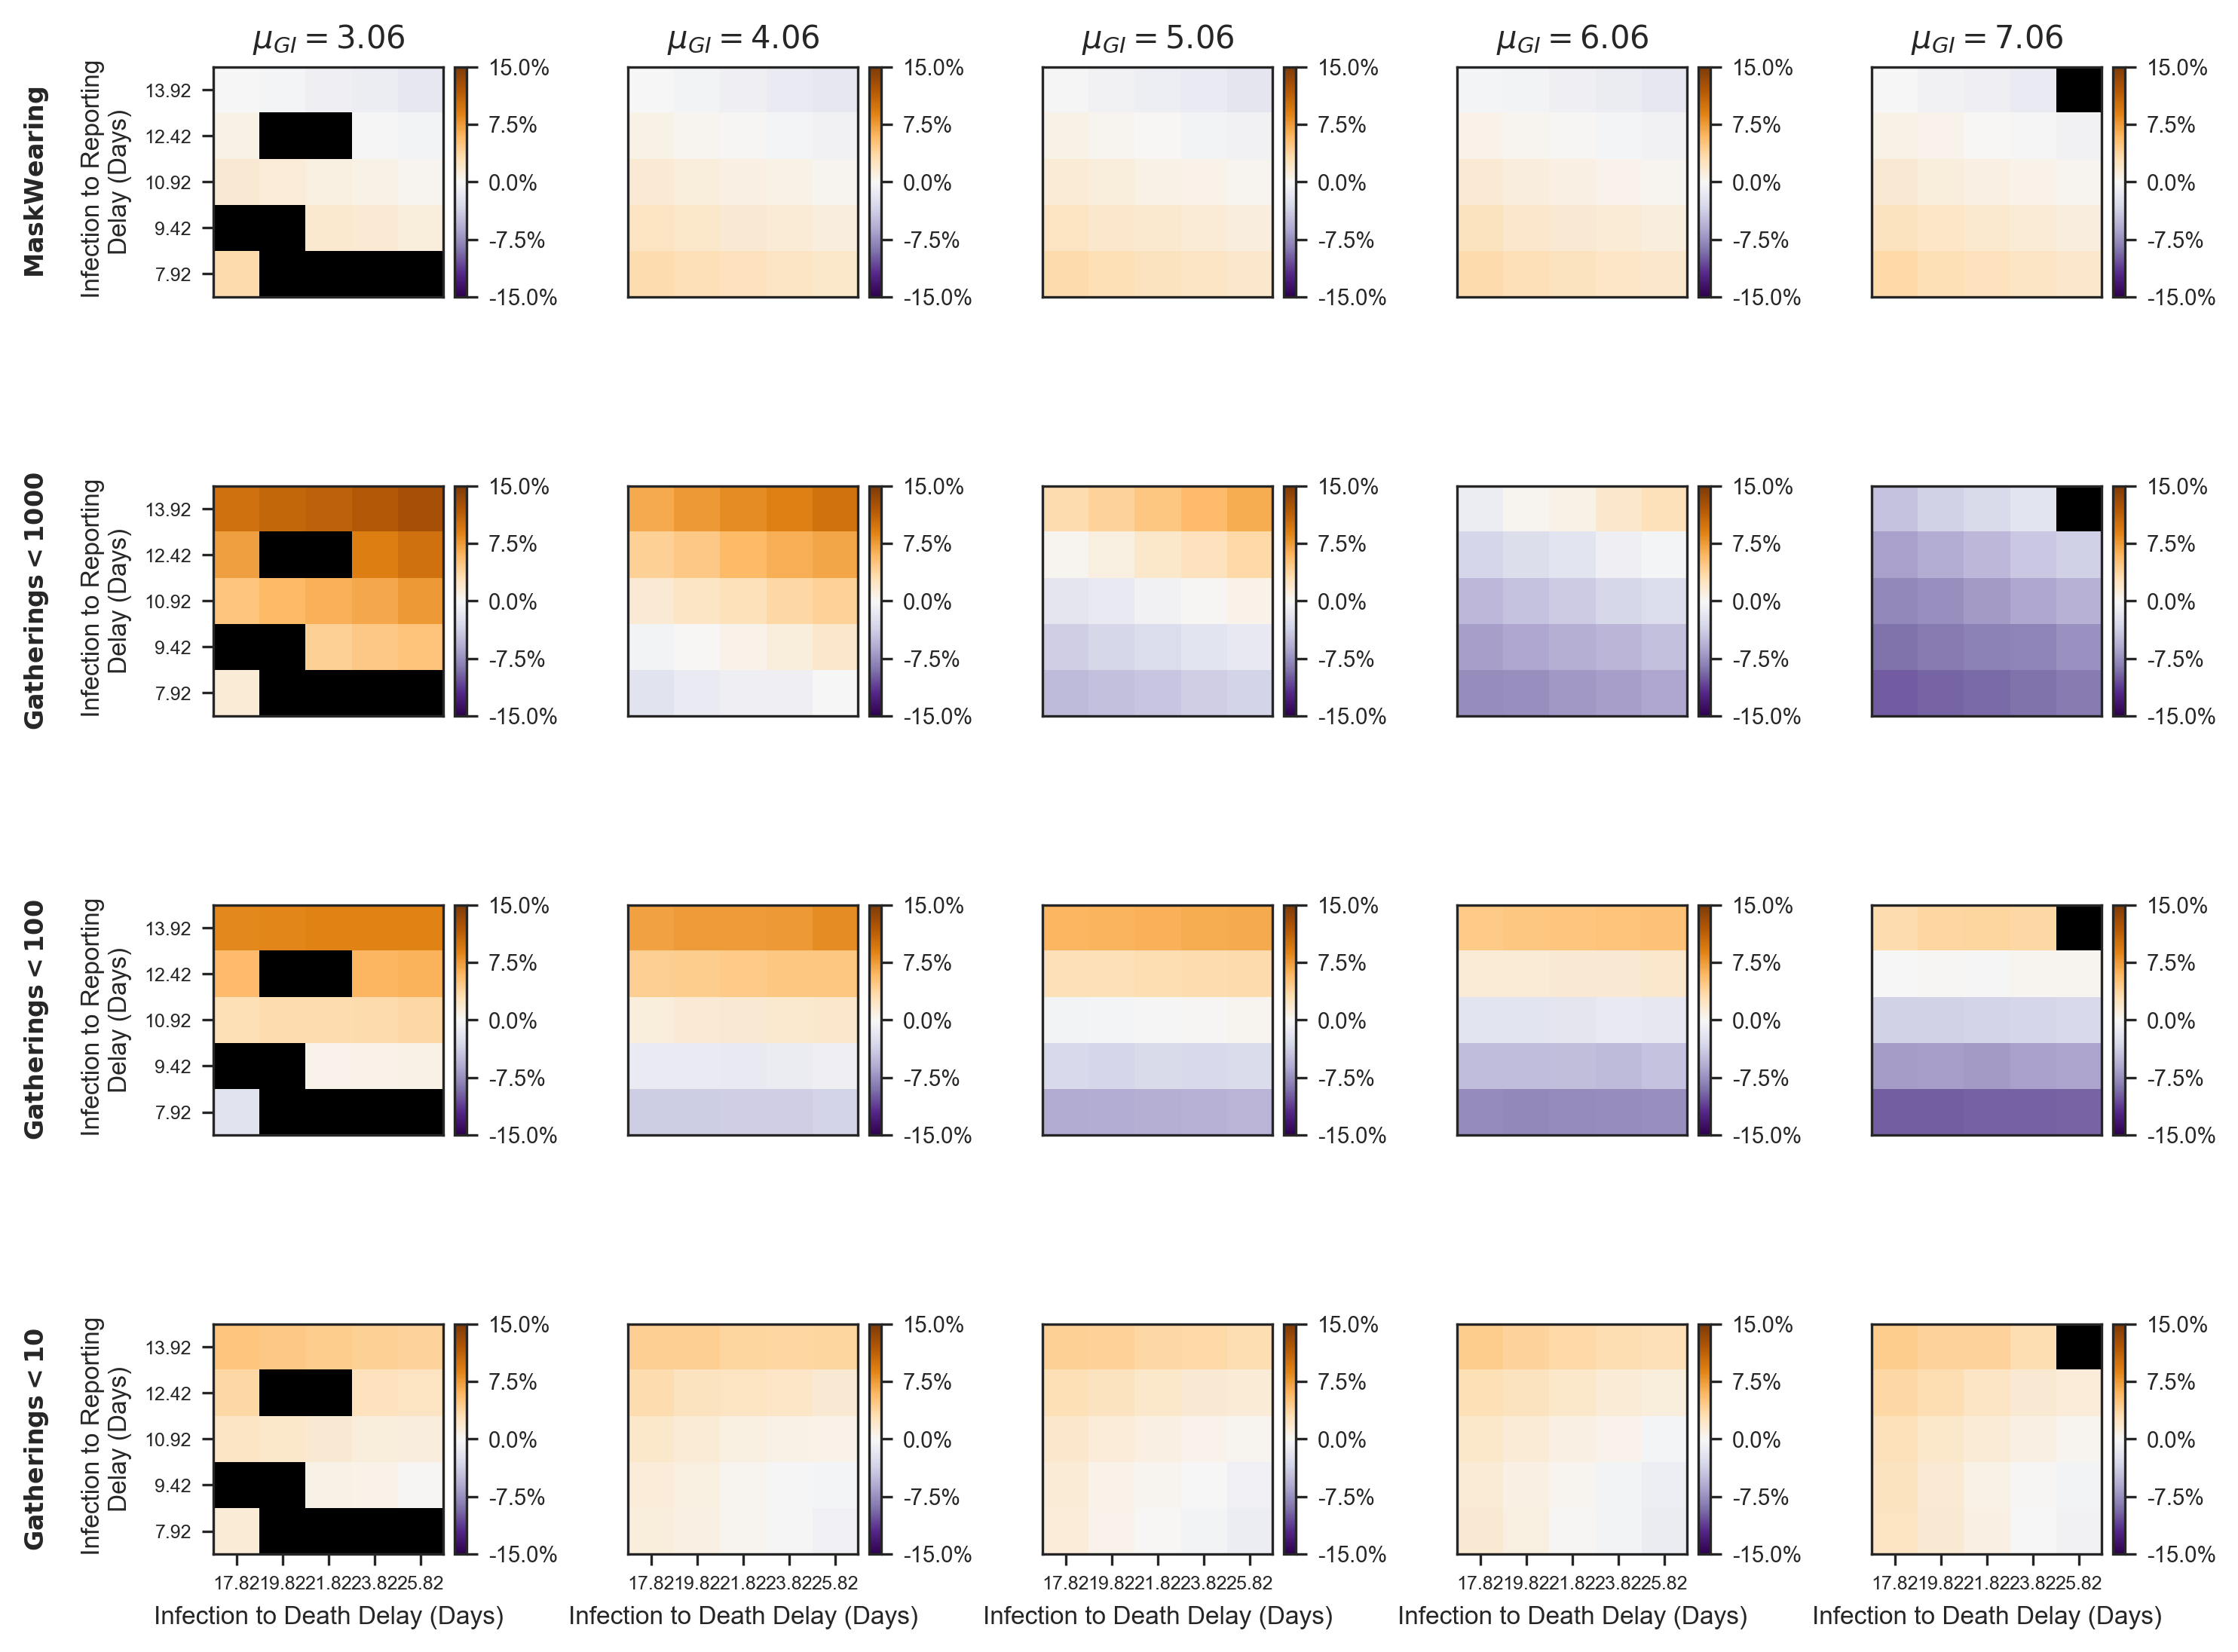

In [480]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

current_cmap = mpl.cm.get_cmap('PuOr_r')
current_cmap.set_bad(color='k')

plt.figure(figsize=(10, 8), dpi=300)
for cm in range(4):
    for gi_ind, gi in enumerate(unique_gis.tolist()):
        plt.subplot(4, 5, 5*cm + gi_ind + 1)
        grid = gi_to_grid(cm, global_traces, unique_cds, unique_dds, gi, default_median)
        im = plt.imshow(grid, cmap=current_cmap, origin='lower', vmin=-15, vmax=15)
        plt.xticks([])
        plt.yticks([])
        
        if cm == 0:
            plt.title(f'$\\mu_{{GI}}={gi:.2f}$', fontsize=10)
        
        if gi_ind == 0:
            plt.ylabel(f'$\\bf{short_names[cm]}$\n\n Infection to Reporting\nDelay (Days)', fontsize=8)
            plt.yticks(np.arange(5), unique_cds, fontsize=6)
            
        if cm == 3:
            plt.xlabel(f'Infection to Death Delay (Days)', fontsize=8)
            plt.xticks(np.arange(5), unique_dds, fontsize=6)
            
        
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
        ax = plt.gca()
        ax.tick_params(axis="both", which="major", labelsize=7)
        cbr.set_ticks([-15, -7.5, 0, 7.5, 15])
#         cbr.set_label('$\\Delta$(Median) Effectivenss\n Estimate', fontsize=8)
        
plt.tight_layout()
plt.savefig(f"figs/validation/FigGlobalSA1FixedValues.pdf", bbox_inches='tight')

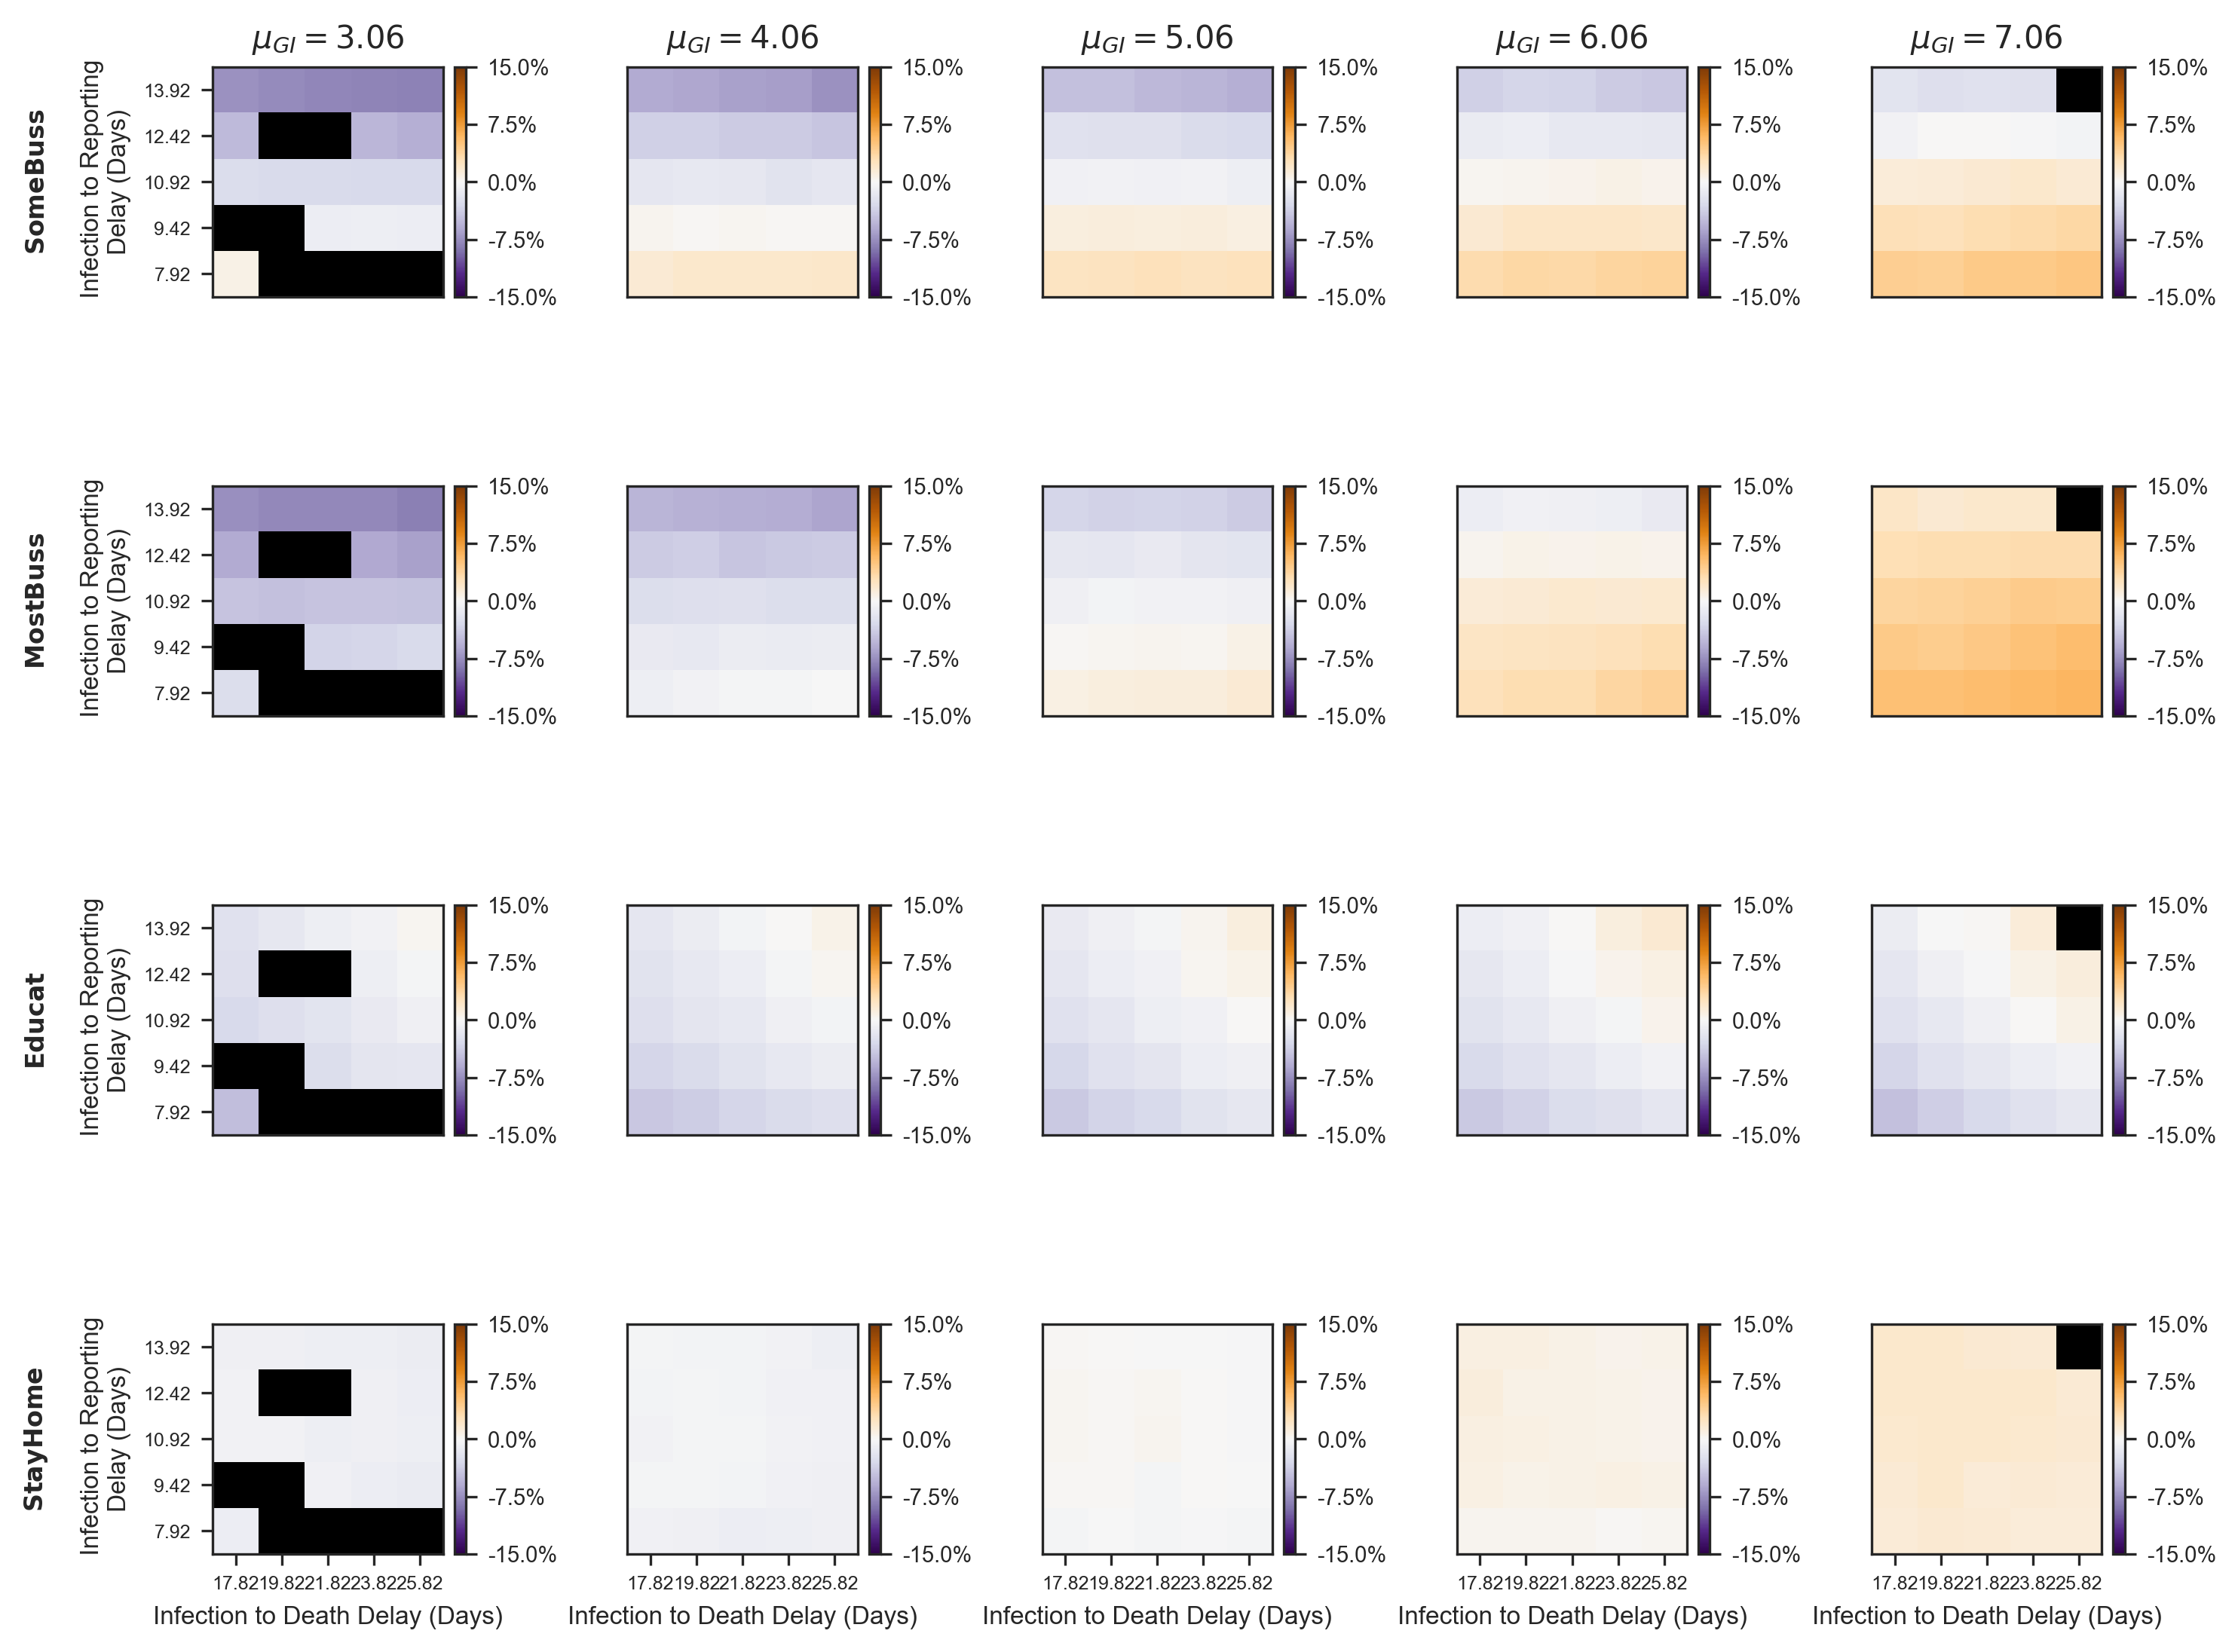

In [479]:
plt.figure(figsize=(10, 8), dpi=300)
for cm_i, cm in enumerate(range(4, 8)):
    for gi_ind, gi in enumerate(unique_gis.tolist()):
        plt.subplot(4, 5, 5*cm_i + gi_ind + 1)
        grid = gi_to_grid(cm, global_traces, unique_cds, unique_dds, gi, default_median)
        im = plt.imshow(grid, cmap=current_cmap, origin='lower', vmin=-15, vmax=15)
        plt.xticks([])
        plt.yticks([])
        
        if cm_i == 0:
            plt.title(f'$\\mu_{{GI}}={gi:.2f}$', fontsize=10)
        
        if gi_ind == 0:
            plt.ylabel(f'$\\bf{short_names[cm]}$\n\n Infection to Reporting\nDelay (Days)', fontsize=8)
            plt.yticks(np.arange(5), unique_cds, fontsize=6)
            
        if cm_i == 3:
            plt.xlabel(f'Infection to Death Delay (Days)', fontsize=8)
            plt.xticks(np.arange(5), unique_dds, fontsize=6)
            
        ax = plt.gca()    
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
        ax = plt.gca()
        ax.tick_params(axis="both", which="major", labelsize=7)
        cbr.set_ticks([-15, -7.5, 0, 7.5, 15])
#         cbr.set_label('$\\Delta$(Median) Effectivenss\n Estimate', fontsize=8)
        
plt.tight_layout()
plt.savefig(f"figs/validation/FigGlobalSA2FixedValues.pdf", bbox_inches='tight')

### Compressed Version

In [481]:
def combine_traces(filter_lambda, global_traces):
    filtered_traces = list(filter(filter_lambda, global_traces))
    
    nF = 9
    samples = np.zeros((0, nF))
    
    for _, _, _, _, t in filtered_traces:
        samples = np.append(samples, t, axis=0)
    
    return samples

In [482]:
cd_traces = []
for unique_cd in unique_cds:
    cd_traces.append((combine_traces(lambda t: t[2] == unique_cd, global_traces), f'Mean {unique_cd} days'))
    
gi_traces = []
for unique_gi in unique_gis:
    gi_traces.append((combine_traces(lambda t: t[1] == unique_gi, global_traces), f'Mean {unique_gi} days'))
    
dd_traces = []
for unique_dd in unique_dds:
    dd_traces.append((combine_traces(lambda t: t[3] == unique_dd, global_traces), f'Mean {unique_dd} days'))

Produced stored using [['Mean 7.92 days', 'Mean 9.42 days', 'Mean 10.92 days', 'Mean 12.42 days', 'Mean 13.92 days']]
Produced stored using [['Mean 17.82 days', 'Mean 19.82 days', 'Mean 21.82 days', 'Mean 23.82 days', 'Mean 25.82 days']]
Produced stored using [['Mean 3.06 days', 'Mean 4.06 days', 'Mean 5.06 days', 'Mean 6.06 days', 'Mean 7.06 days']]


'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


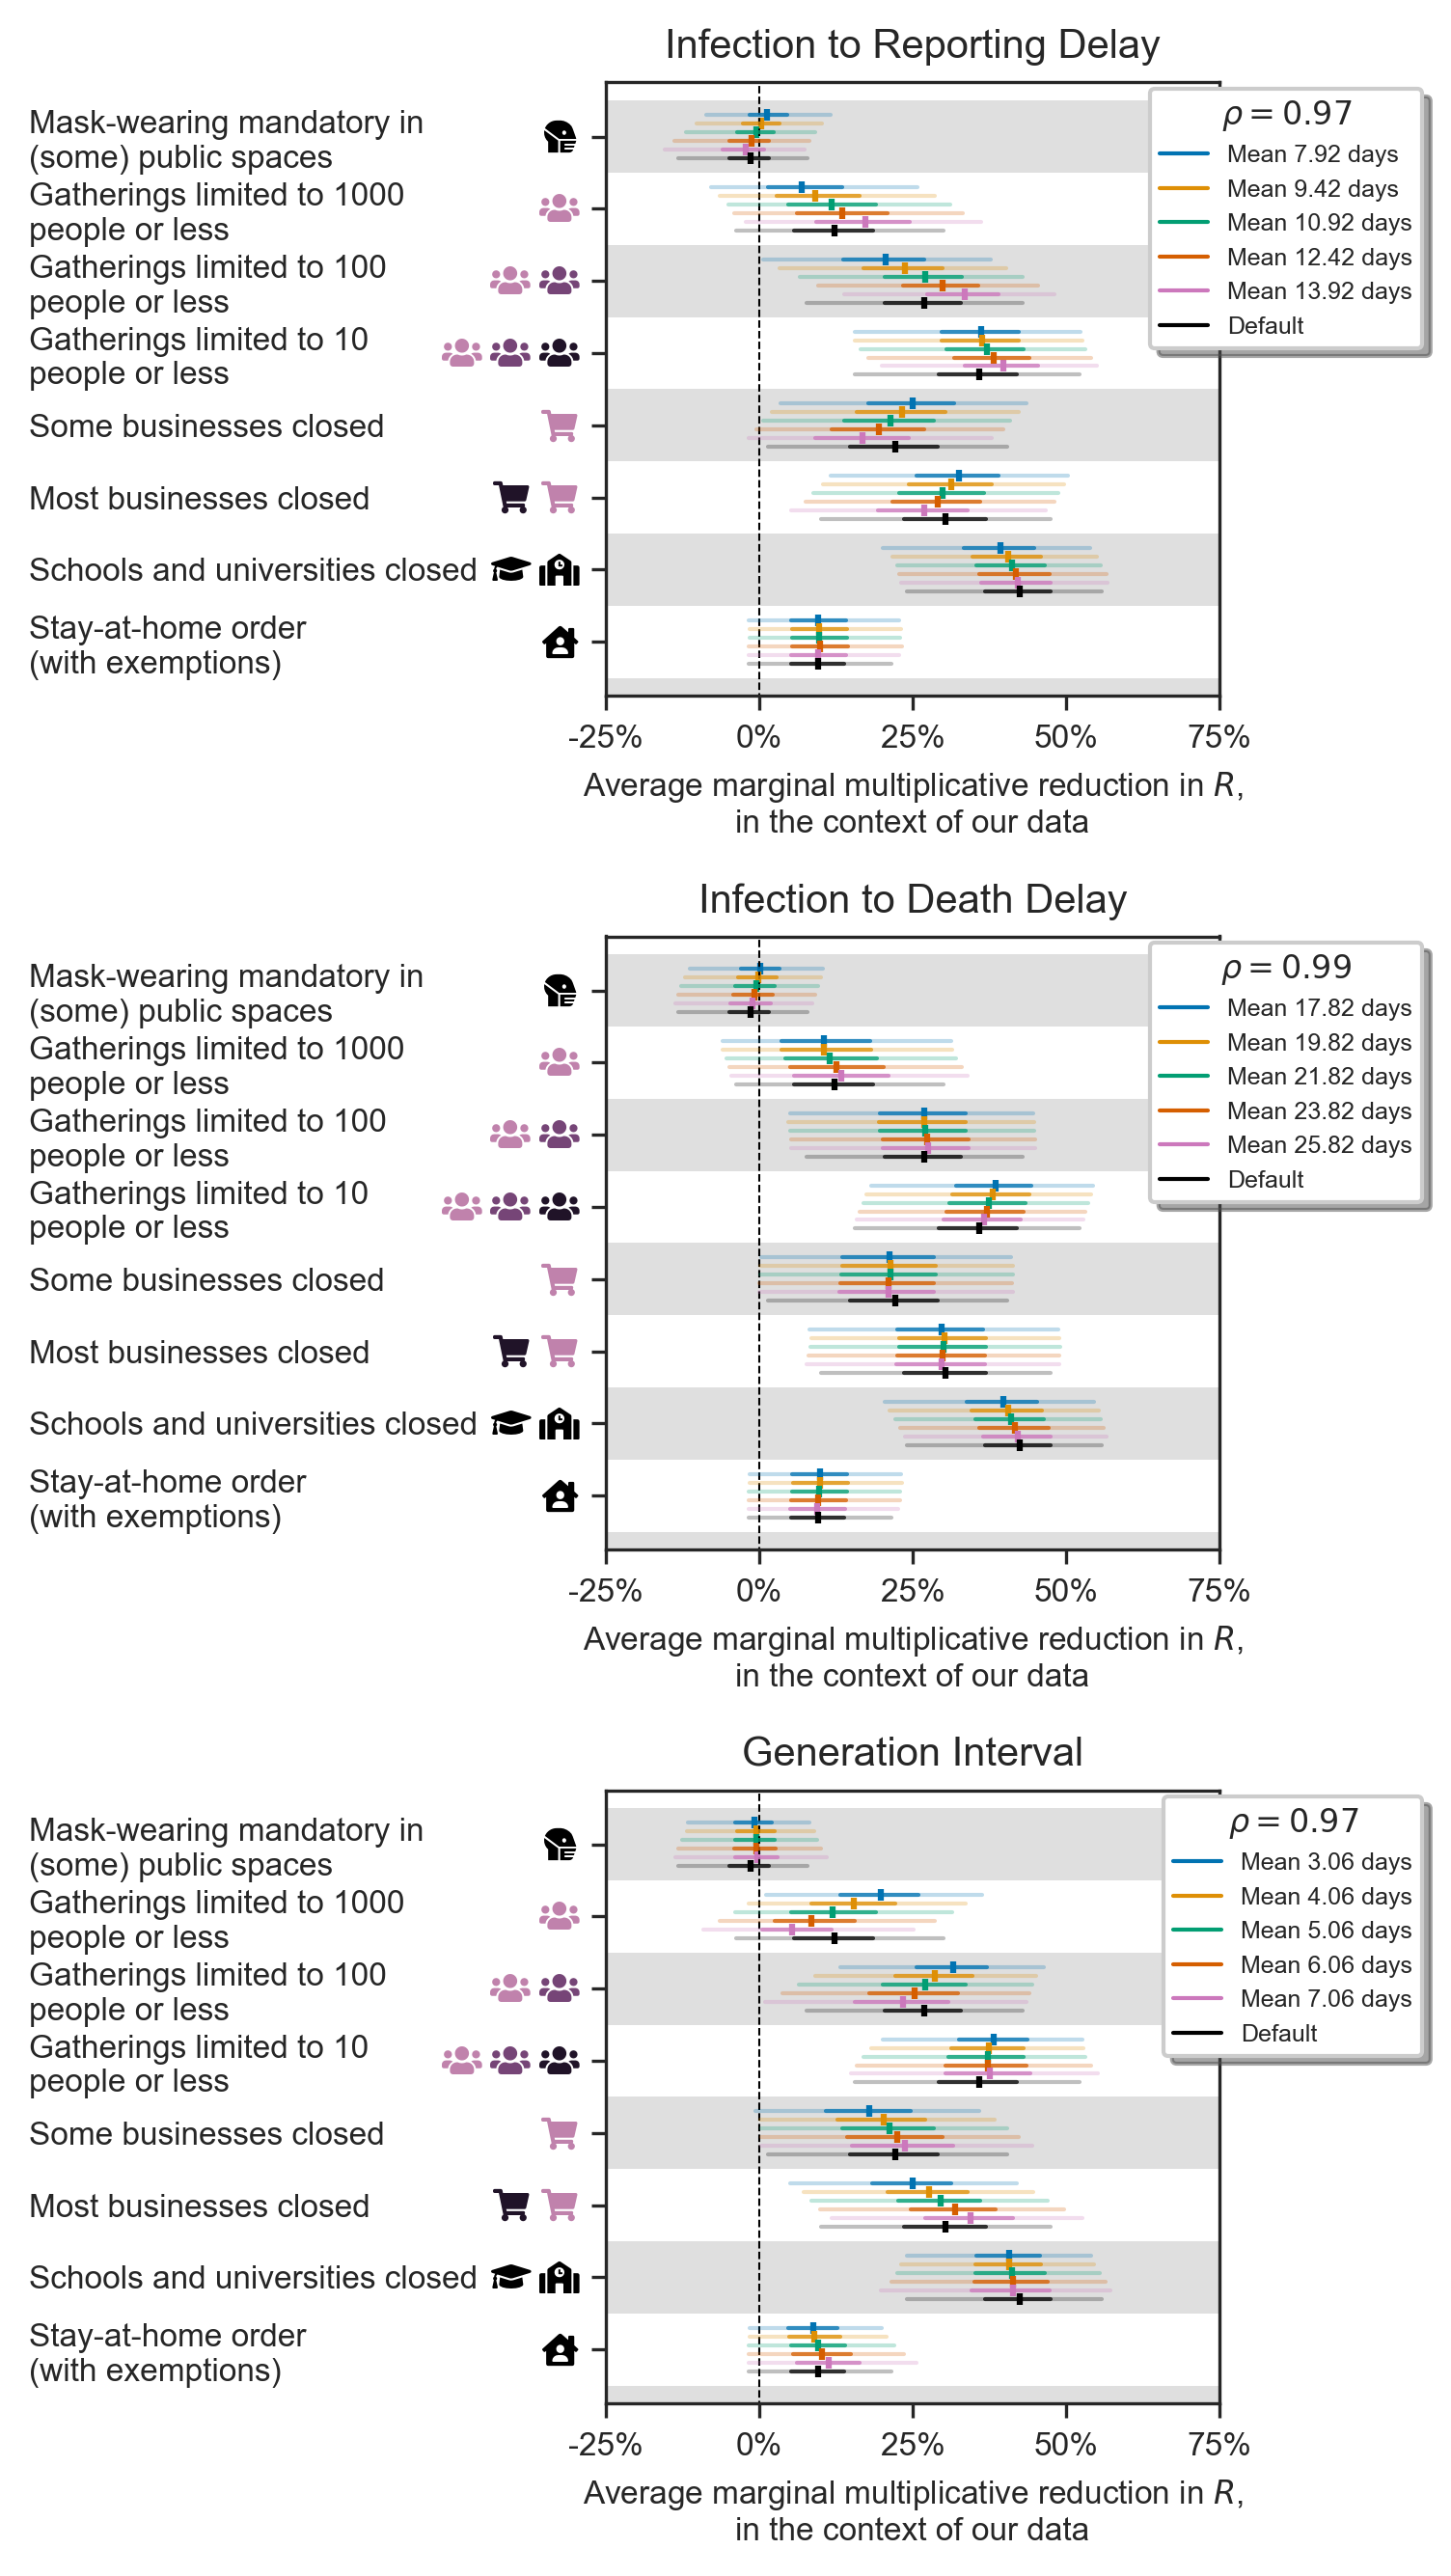

In [485]:
fig = plt.figure(figsize=(6, 9), dpi=300)
plt.subplot(311)
setup_large_plot()
score = produce_score(default_res, cd_traces)
y_off = -np.linspace(-0.3, 0.3, len(cd_traces)+1)
width = 1
for i, (trace, label) in enumerate(cd_traces):
    add_trace_to_plot(trace, y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Infection to Reporting Delay", fontsize="10")

plt.subplot(312)
score = produce_score(default_res, dd_traces)
setup_large_plot()
y_off = -np.linspace(-0.3, 0.3, len(dd_traces)+1)
width = 1
for i, (trace, label) in enumerate(dd_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Infection to Death Delay", fontsize="10")

plt.subplot(313)
score = produce_score(default_res, gi_traces)
setup_large_plot()
y_off = -np.linspace(-0.3, 0.3, len(gi_traces)+1)
width = 1
for i, (trace, label) in enumerate(gi_traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.35, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("Generation Interval", fontsize="10")

plt.tight_layout()
plt.savefig(f"figs/validation/FigGlobalSACompFixedValues.pdf", bbox_inches='tight')

In [486]:
f;

# ascertainment rates

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=300)
plt.subplot(121)
setup_large_plot()

derived_features = derived_features_comb
traces = load_tagged_traces(results_base_dir, "ascertainment_rate")
score = produce_score(default_res, traces)

y_off = -np.linspace(-0.2, 0.2, len(traces)+1)
width = 2
for i, (trace, label) in enumerate(traces):
    add_trace_to_plot(trace[:, :9], y_off[i], colors[i], label, 1, width)
add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.95, 1.01), fontsize=6, title=f'$\\rho={score:.2f}$', title_fontsize=8)
plt.title("NPI Timing: Miscellaneous", fontsize="10")


plt.title("NPI Timing: Order", fontsize="10")
plt.tight_layout()
plt.savefig(f"figs/validation/FigureNPITiming.pdf", bbox_inches='tight')